In [1]:
import numpy as np
import pandas as pd
from plotnine import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In this notebook, we replace outliers in predictor columns with `np.nan`'s.

In [2]:
harp_data = pd.read_parquet("../../processed/hq_nc70.parquet")
harp_data.head()

,HARPNUM,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,LON_FWT,LAT_FWTPOS,LON_FWTPOS,LAT_FWTNEG,LON_FWTNEG,T_FRST1,T_LAST1,NOAA_AR,NOAA_NUM,NOAA_ARS
0,1,2010-05-01 14:00:00+00:00,5.827622e+21,23.887,73.347,77.564,31.354,-0.151826,4.860817e+12,0.000398,...,-69.996475,23.742485,-70.418633,23.806280,-67.113625,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
1,1,2010-05-01 14:12:00+00:00,5.768150e+21,24.708,71.970,76.249,31.197,-0.226835,4.908301e+12,0.000081,...,-69.953972,23.769396,-70.363503,23.788214,-67.011284,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
2,1,2010-05-01 14:24:00+00:00,5.865157e+21,25.657,74.254,82.154,32.748,-0.260023,5.577384e+12,-0.009573,...,-69.793488,23.754747,-70.199081,23.777744,-66.899902,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
3,1,2010-05-01 14:36:00+00:00,5.854875e+21,25.242,74.539,81.896,33.026,-0.199640,5.290721e+12,-0.013852,...,-69.734100,23.757551,-70.166977,23.768915,-66.779518,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067
4,1,2010-05-01 14:48:00+00:00,5.854465e+21,25.876,75.671,85.297,33.556,-0.403703,5.911234e+12,-0.012455,...,-69.602234,23.720182,-70.012299,23.794512,-66.671707,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067


The predictor columns are listed below.

In [3]:
all_predictors = [
    # SHARP parameters
    "USFLUX", "MEANGAM", "MEANGBT", "MEANGBZ", "MEANGBH", "MEANJZD", "TOTUSJZ",
    "MEANALP", "MEANJZH", "TOTUSJH", "ABSNJZH", "SAVNCPP", "MEANPOT", "TOTPOT",
    "MEANSHR", "SHRGT45",
    # Patch areas and pixel counts
    "NPIX", "SIZE", "AREA", "NACR", "SIZE_ACR", "AREA_ACR"
]

We will use the function below to make histograms for the predictors; the
histograms will be used to identify values that seem to be implausibly small or
large.

In [4]:
def make_histogram(
        predictor: str,
        low_quantile_level: float = None,
        high_quantile_level: float = None,
        bins: int = 1000,
        use_log_scale_for_y: bool = False
    ) -> ggplot:
    predictor_vals = harp_data[predictor]
    if low_quantile_level is None and high_quantile_level is None:
        mask = pd.Series([True] * predictor_vals.size)
        divisor = np.amax(np.abs([predictor_vals.min(), predictor_vals.max()]))
        caption = None
    elif low_quantile_level is not None and high_quantile_level is None:
        low_quantile = predictor_vals.quantile(low_quantile_level)
        mask = predictor_vals >= low_quantile
        divisor = np.abs(low_quantile)
        caption = (
            f"Values below {low_quantile_level} quantile ({low_quantile:.2g})"
            " are excluded"
        )
    elif low_quantile_level is None and high_quantile_level is not None:
        high_quantile = predictor_vals.quantile(high_quantile_level)
        mask = predictor_vals <= high_quantile
        divisor = np.abs(high_quantile)
        caption = (
            f"Values above {high_quantile_level} quantile ({high_quantile:.2g})"
            " are excluded"
        )
    else:
        low_quantile = predictor_vals.quantile(low_quantile_level)
        high_quantile = predictor_vals.quantile(high_quantile_level)
        mask = predictor_vals.between(low_quantile, high_quantile)
        divisor = np.amax(np.abs([low_quantile, high_quantile]))
        caption = (
            f"Values below {low_quantile_level} quantile ({low_quantile:.2g})"
            f" or above {high_quantile_level} quantile ({high_quantile:.2g})"
            " are excluded"
        )

    divisor = 1 if np.isclose(divisor, 0) else divisor
    # plotnine can have trouble plotting large numbers, hence this hack
    predictor_vals = predictor_vals[mask] / divisor
    histogram = (
        ggplot(pd.DataFrame(predictor_vals), aes(predictor)) +
        geom_histogram(bins=bins) +
        scale_x_continuous(
            labels=lambda breakpoints: [
                f"{breakpoint * divisor:.2g}" for breakpoint in breakpoints
            ]
        ) +
        labs(y="Number of Records", caption=caption) +
        theme_bw() +
        theme(
            panel_grid_major_x=element_blank(),
            panel_grid_minor_x=element_blank()
        )
    )
    if use_log_scale_for_y:
        histogram = histogram + scale_y_log10()

    return histogram

There don't seem to be any dubious values of `USFLUX`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


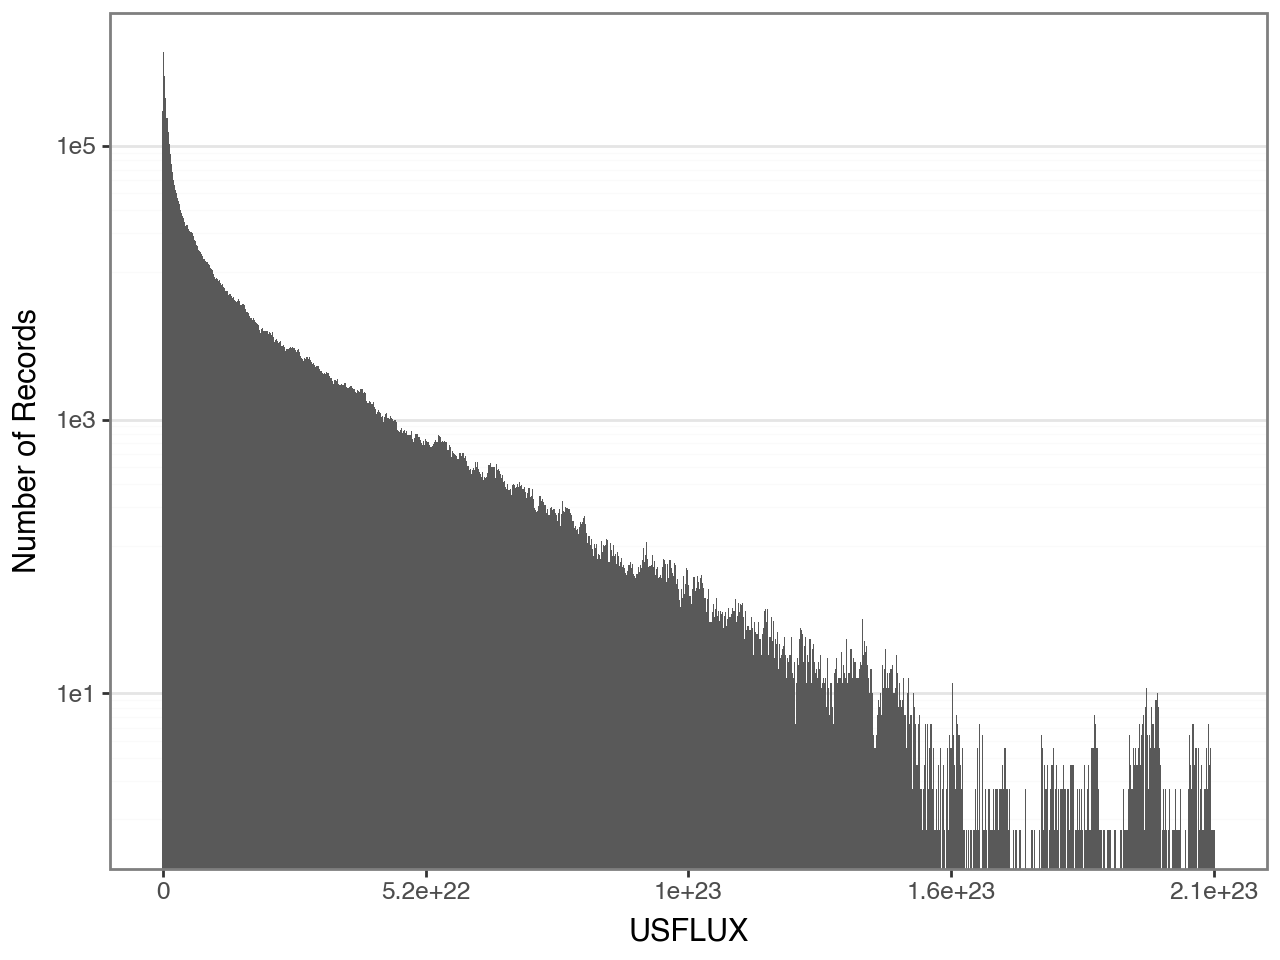

In [5]:
make_histogram("USFLUX", use_log_scale_for_y=True)

There don't seem to be any dubious values of `MEANGAM`.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696373 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


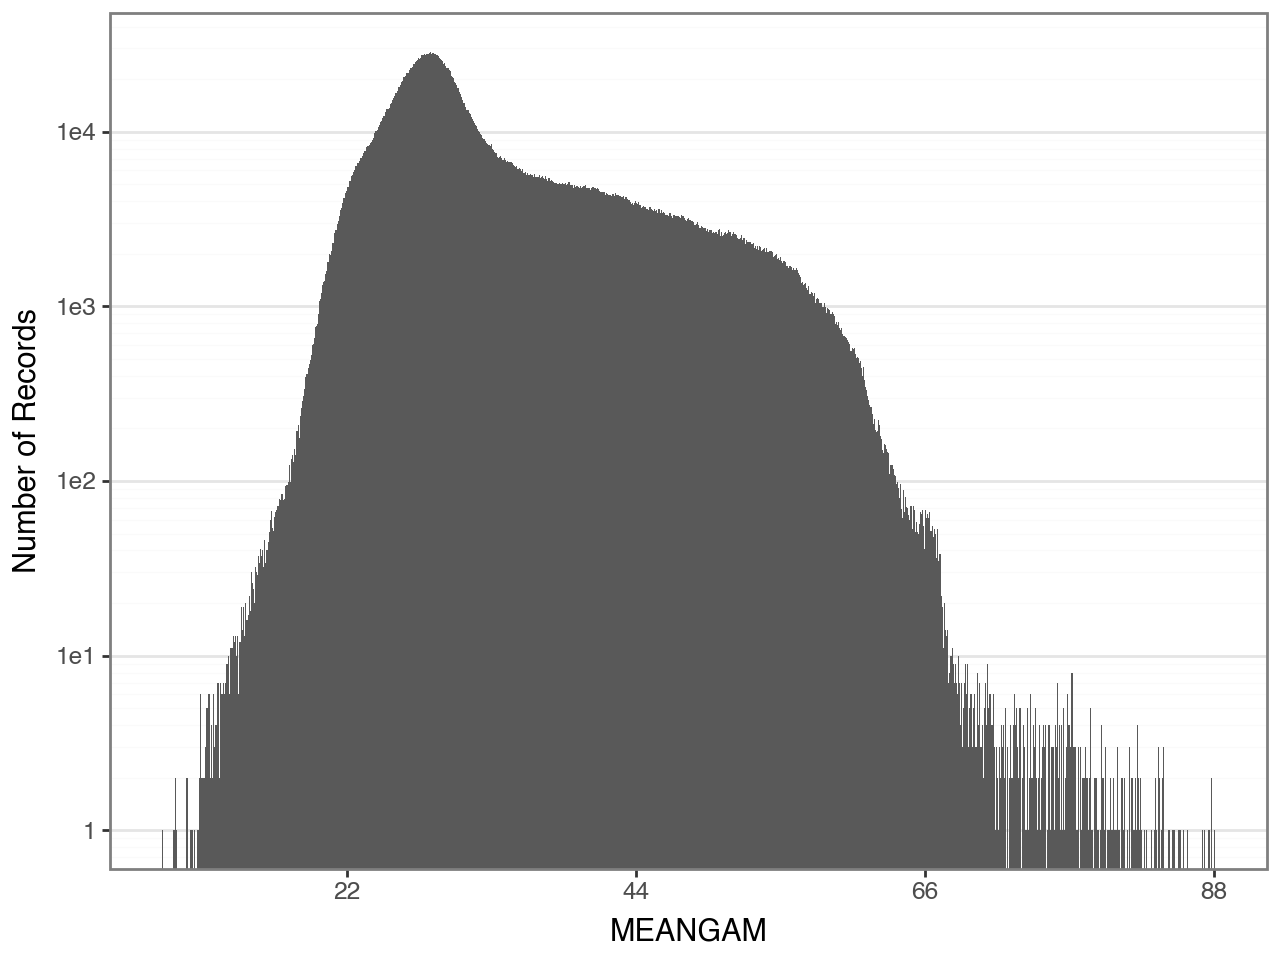

In [6]:
make_histogram("MEANGAM", use_log_scale_for_y=True)

There is a value of `MEANBGT` around 660 that looks dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696316 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


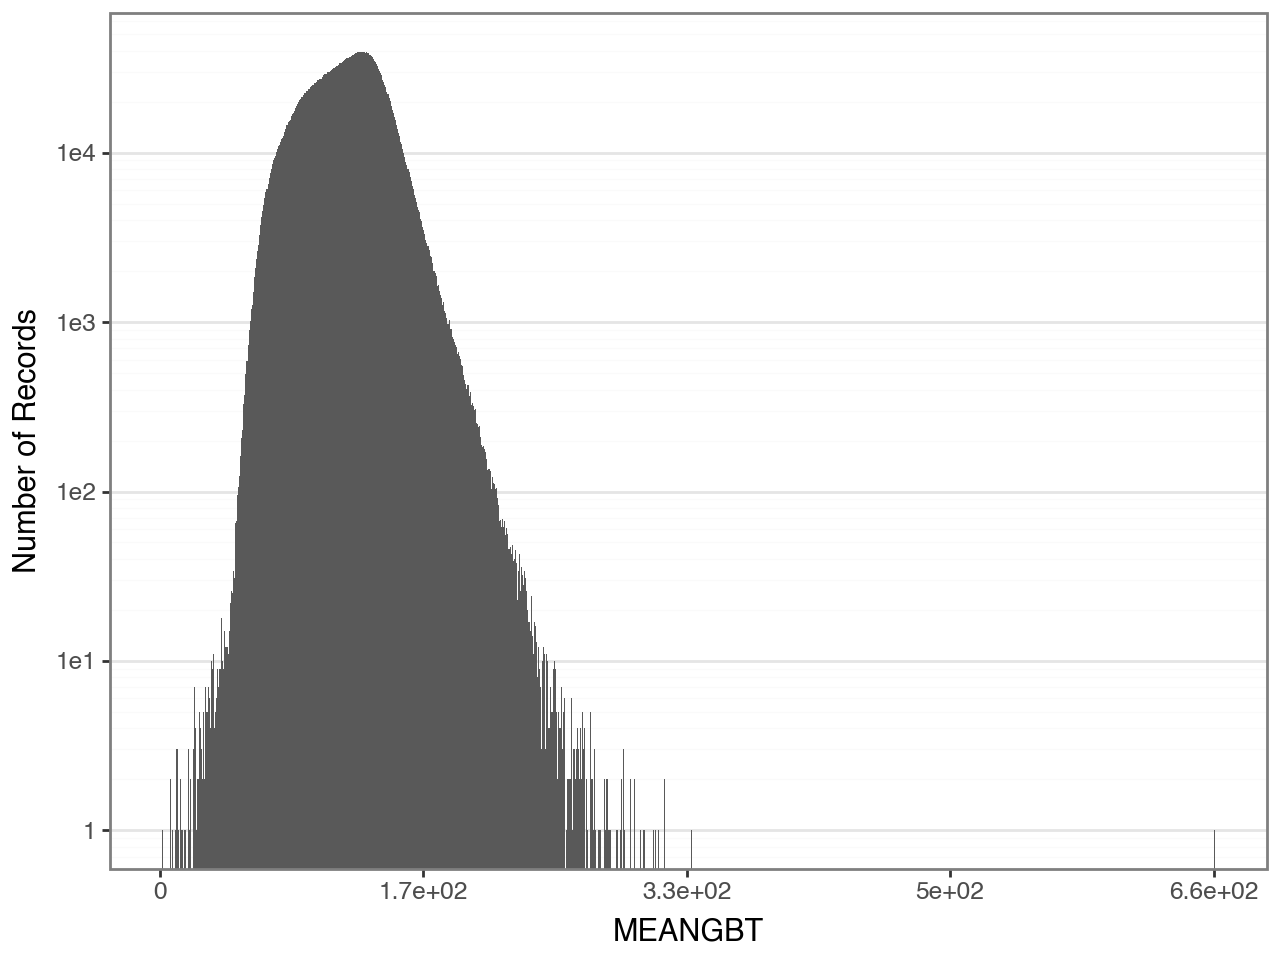

In [7]:
make_histogram("MEANGBT", use_log_scale_for_y=True)

We replace the dubious value with `np.nan`.

In [8]:
harp_data.loc[harp_data["MEANGBT"] > 600, "MEANGBT"] = np.nan

There is a dubious value of `MEANGBZ` around 530.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696307 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


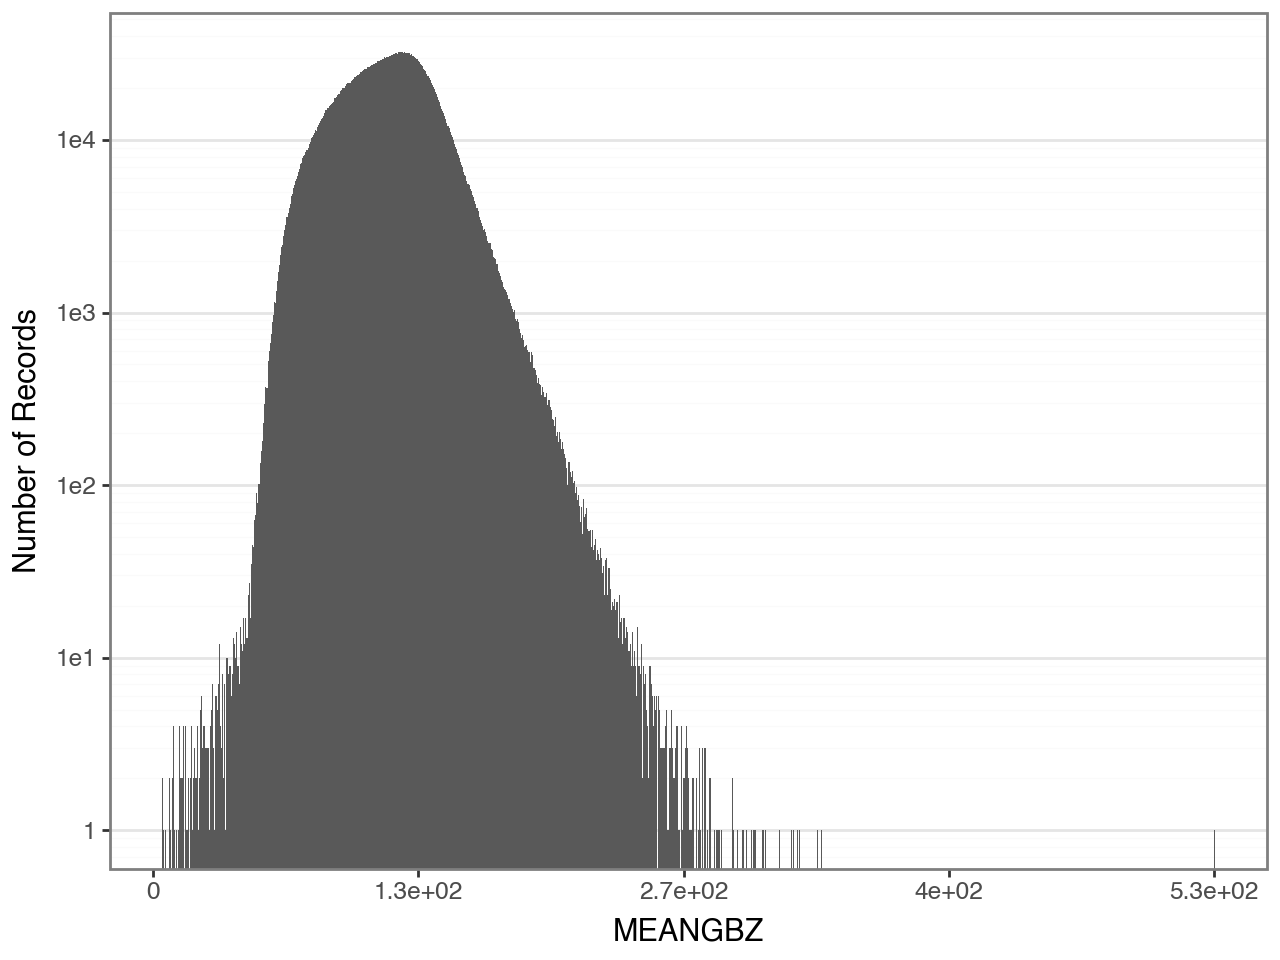

In [9]:
make_histogram("MEANGBZ", use_log_scale_for_y=True)

We replace the dubious value with `np.nan`.

In [10]:
harp_data.loc[harp_data["MEANGBZ"] > 500, "MEANGBZ"] = np.nan

Values of `MEANGBH` above around 170 look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696307 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


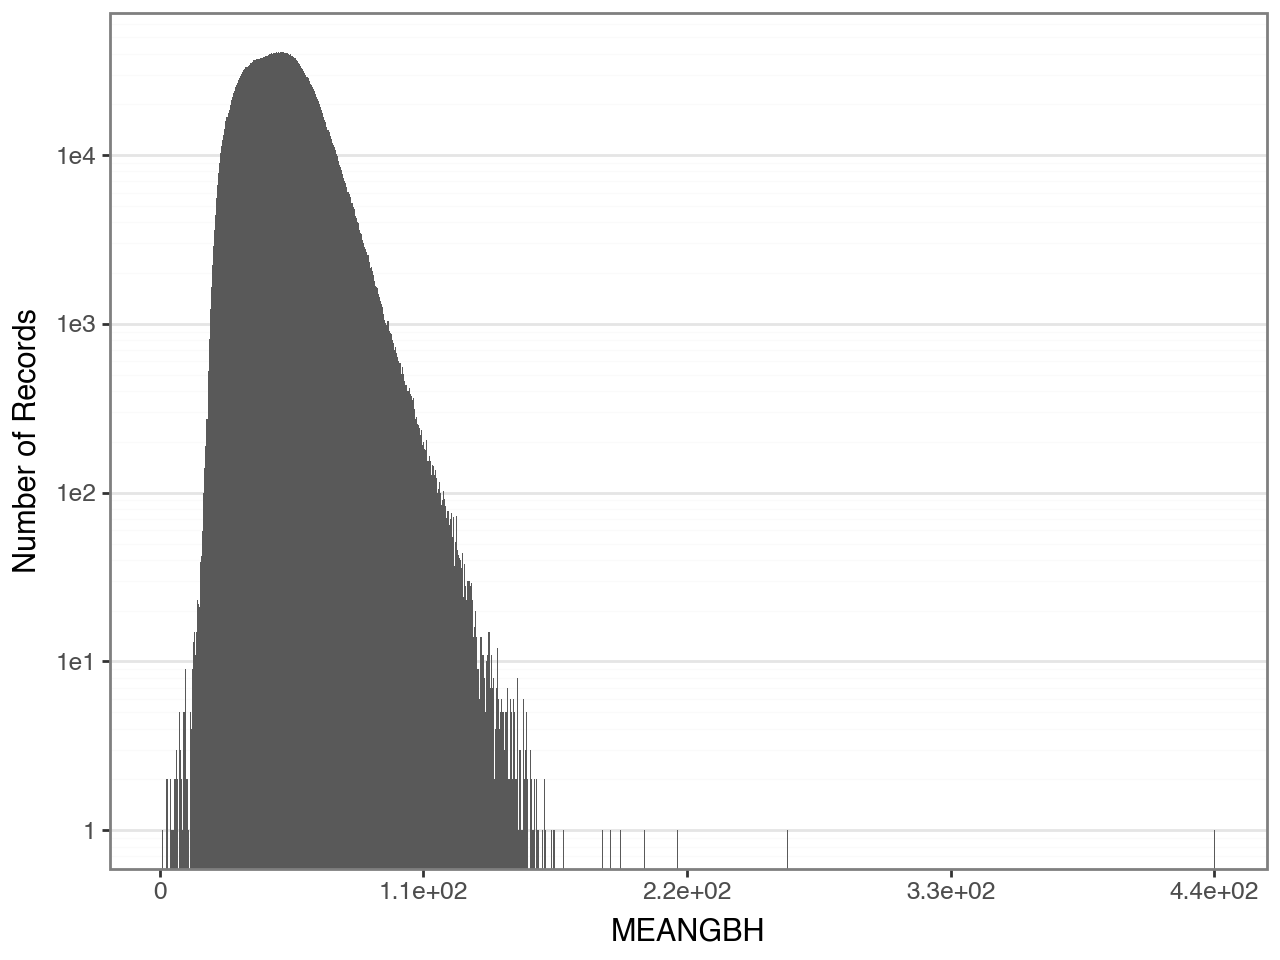

In [11]:
make_histogram("MEANGBH", use_log_scale_for_y=True)

We replace the dubious values with `np.nan`.

In [12]:
harp_data.loc[harp_data["MEANGBH"] > 170, "MEANGBH"] = np.nan

Values of `MEANJZD` that are below the `1e-5` quantile or above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


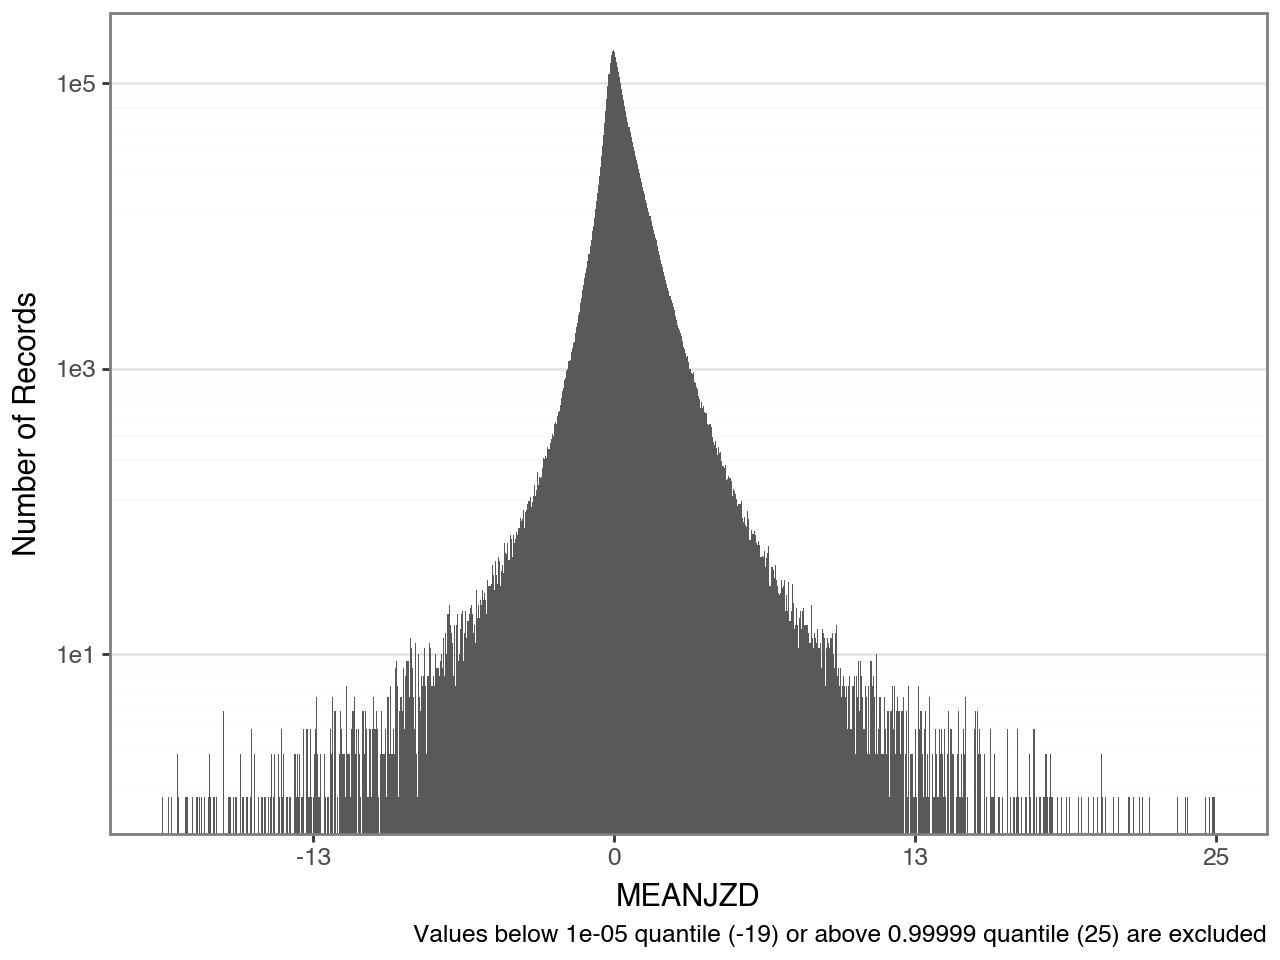

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


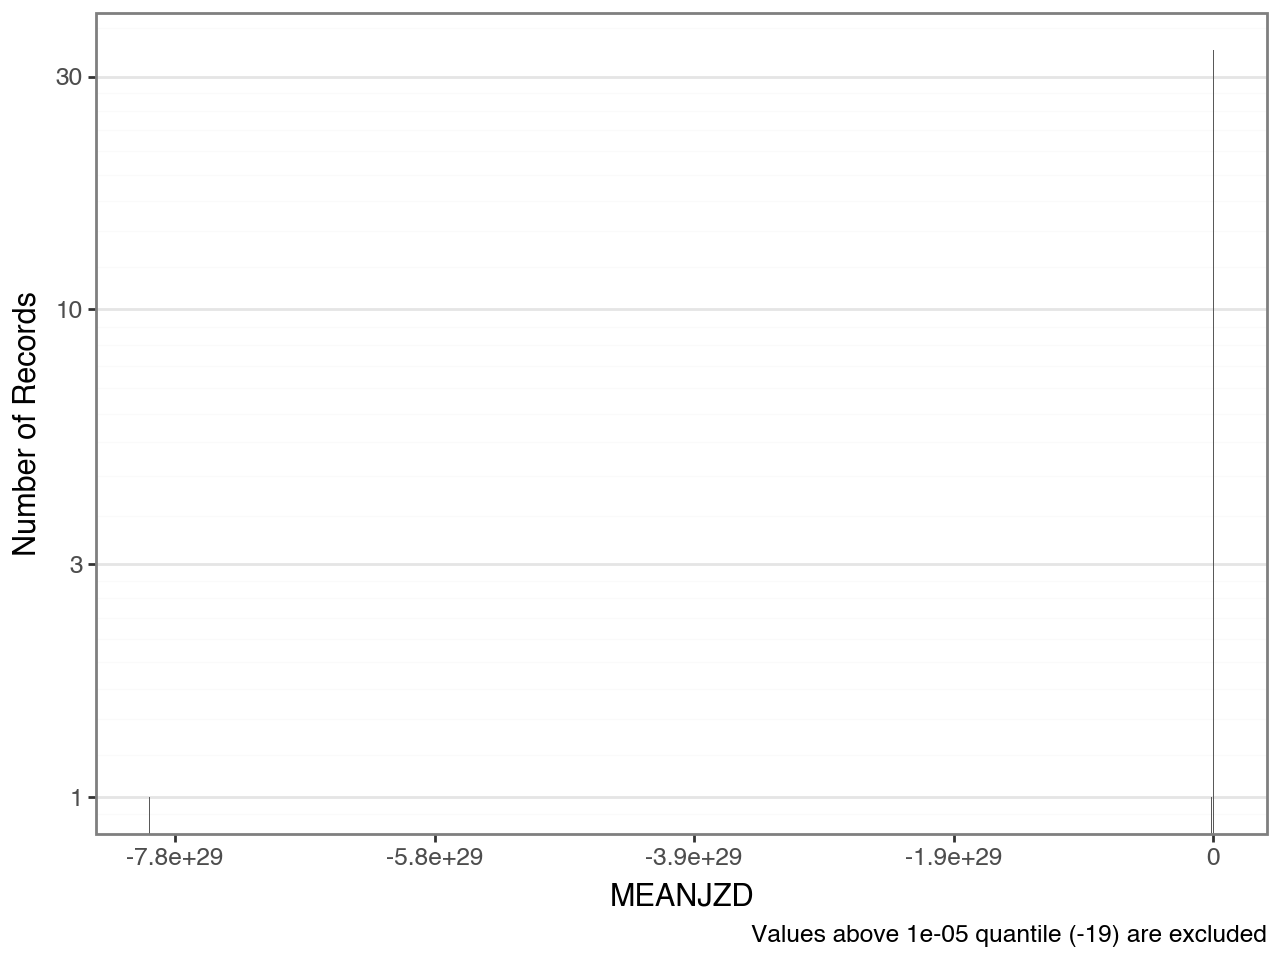

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


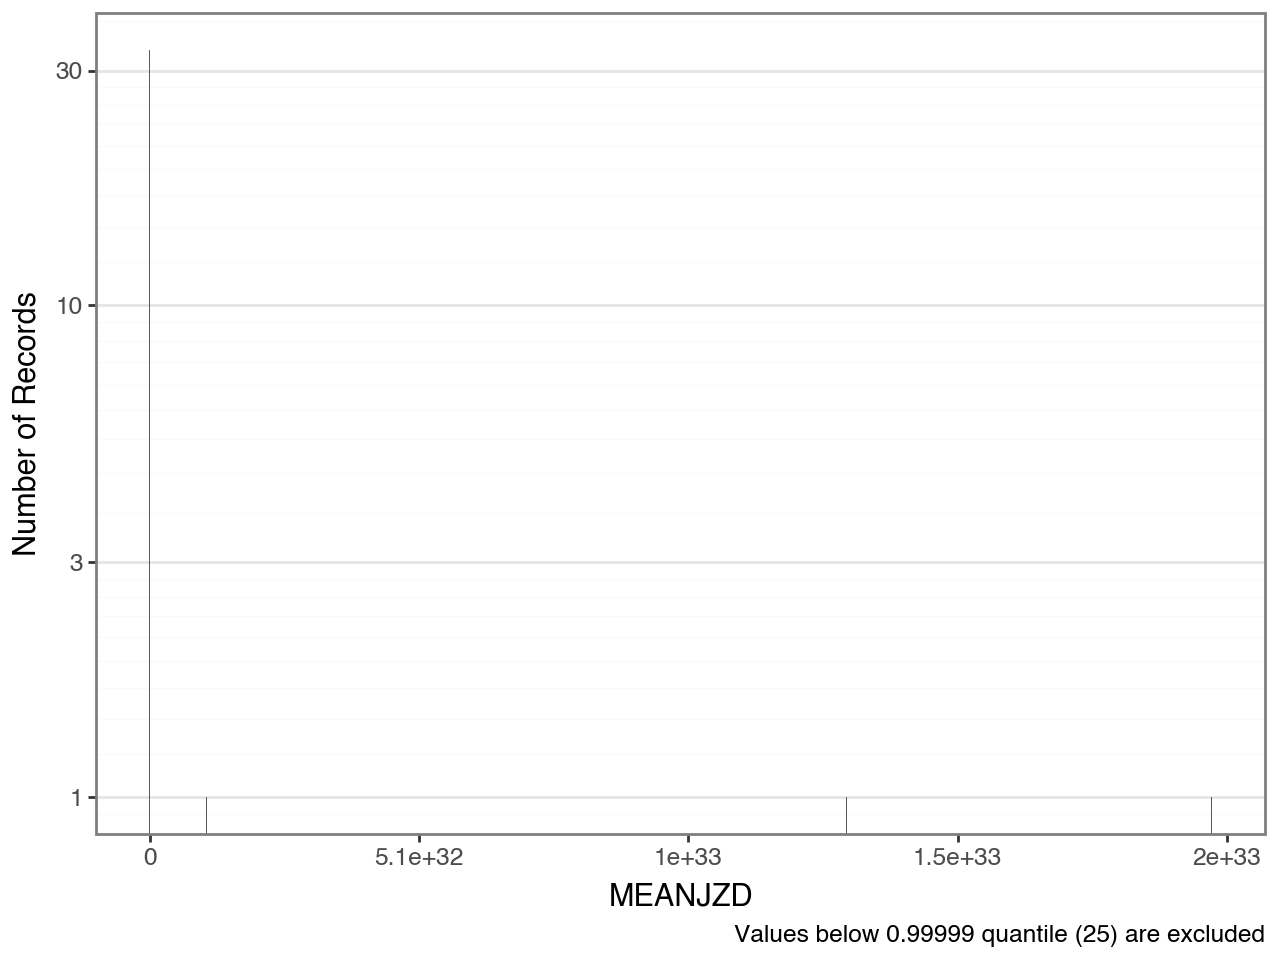

In [13]:
meanjzd_body_histogram = make_histogram(
    "MEANJZD",
    low_quantile_level=1e-5, high_quantile_level=1 - 1e-5,
    use_log_scale_for_y=True
)
meanjzd_left_tail_histogram = make_histogram(
    "MEANJZD", high_quantile_level=1e-5, use_log_scale_for_y=True
)
meanjzd_right_tail_histogram = make_histogram(
    "MEANJZD", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
meanjzd_body_histogram.show()
meanjzd_left_tail_histogram.show()
meanjzd_right_tail_histogram

We replace the dubious values with `np.nan`.

In [14]:
meanjzd_quantiles = harp_data["MEANJZD"].quantile([1e-5, 1 - 1e-5])
harp_data.loc[
    ~harp_data["MEANJZD"].between(
        meanjzd_quantiles.iloc[0], meanjzd_quantiles.iloc[1]
    ),
    "MEANJZD"
] = np.nan

Values of `TOTUSJZ` above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


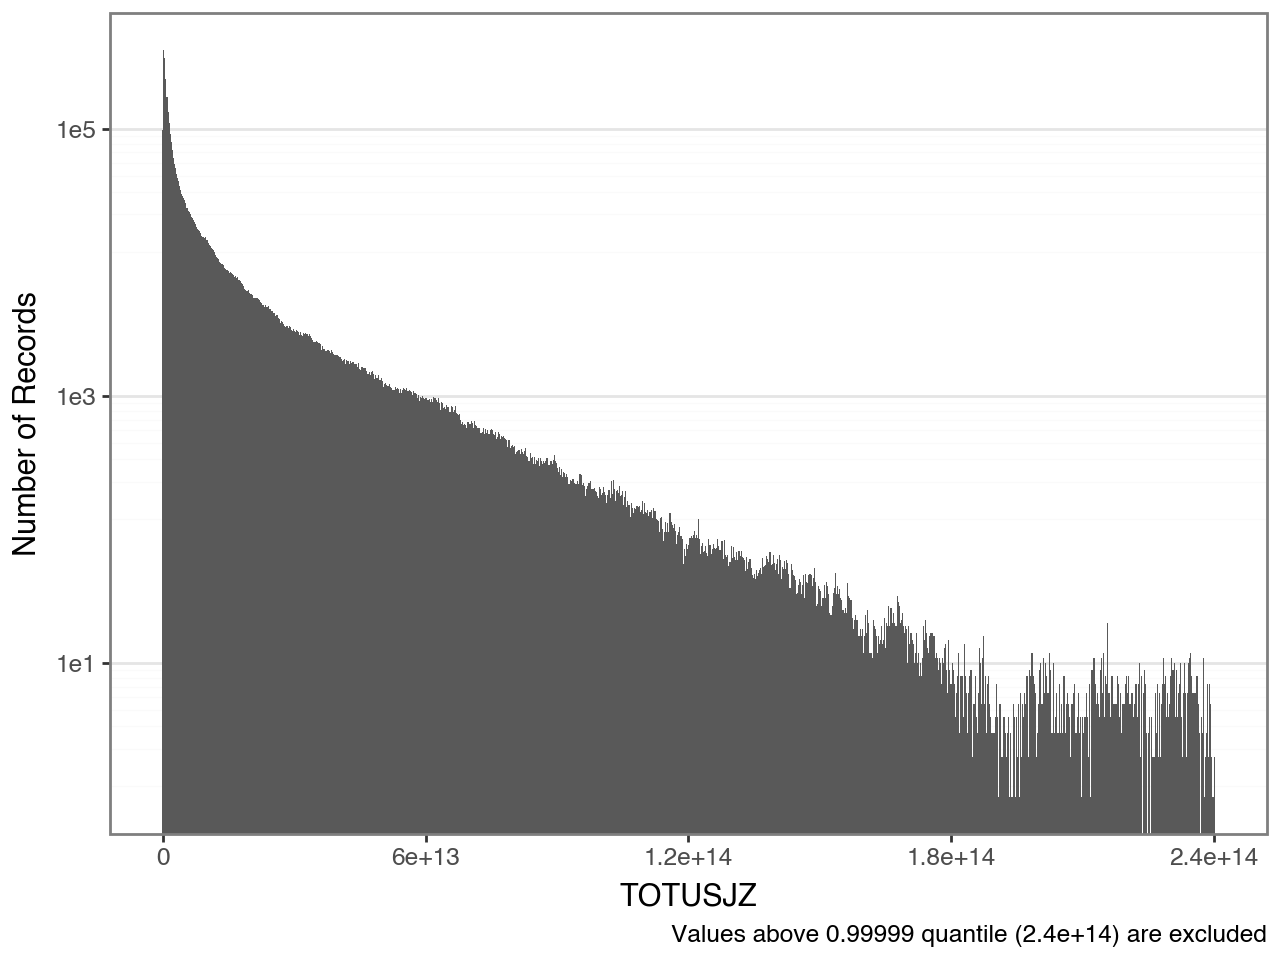

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


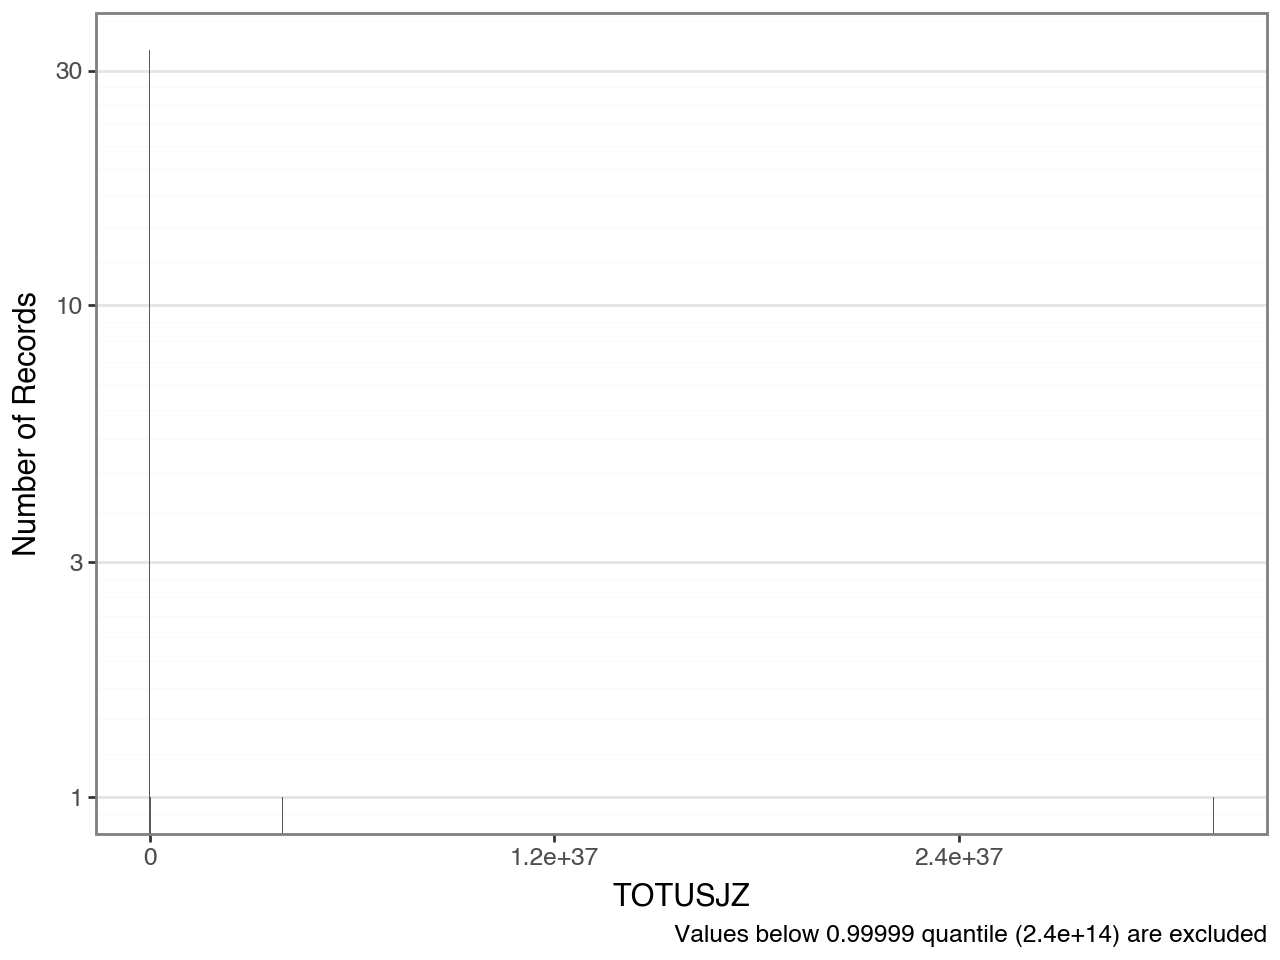

In [15]:
totusjz_body_histogram = make_histogram(
    "TOTUSJZ", high_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
totusjz_right_tail_histogram = make_histogram(
    "TOTUSJZ", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
totusjz_body_histogram.show()
totusjz_right_tail_histogram

We replace the dubious values with `np.nan`.

In [16]:
harp_data.loc[
    harp_data["TOTUSJZ"] > harp_data["TOTUSJZ"].quantile(1 - 1e-5), "TOTUSJZ"
] = np.nan

Values of `MEANALP` that are below around -3 or above around 3 look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696316 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


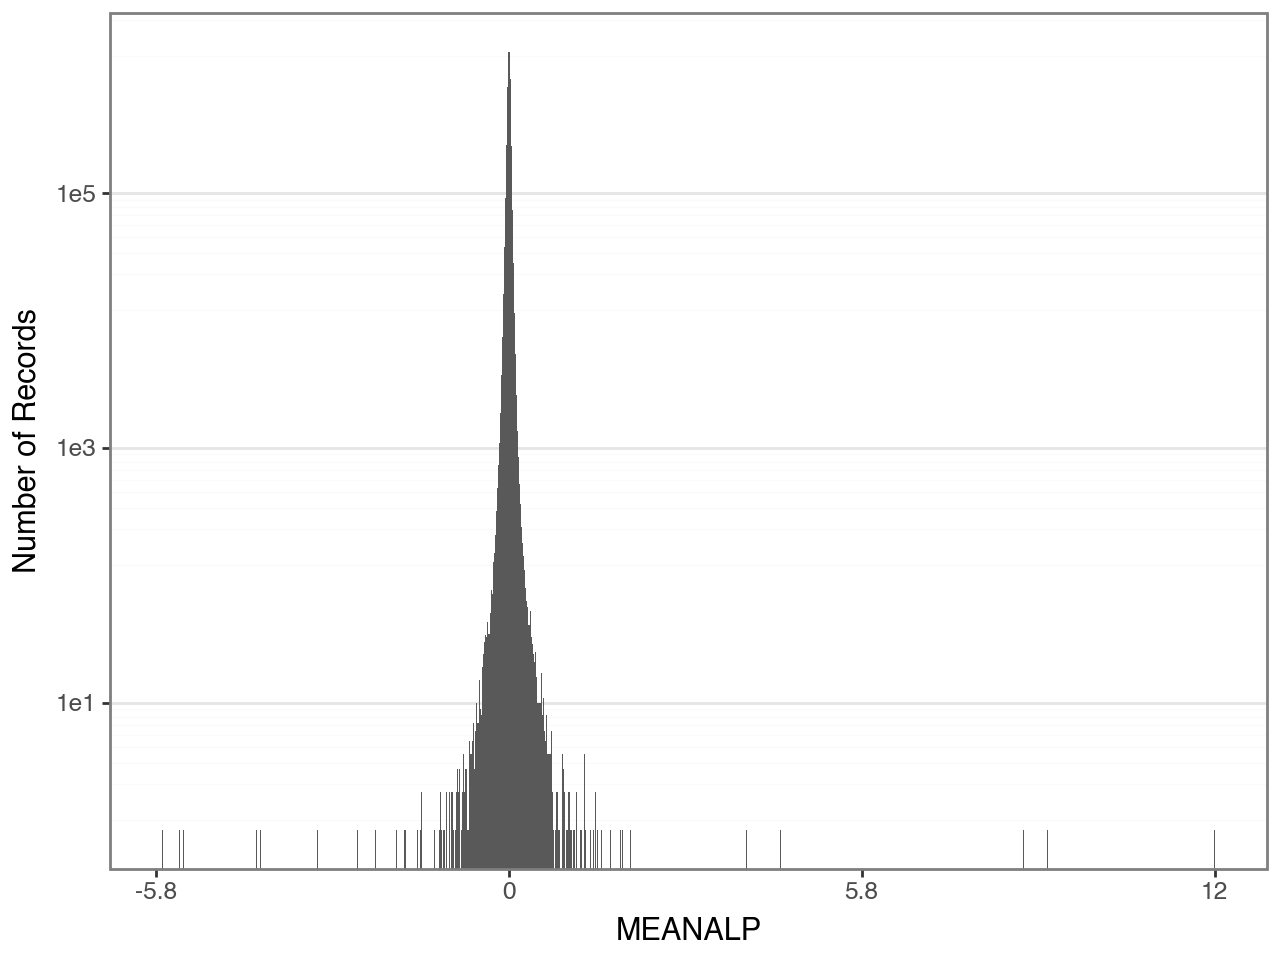

In [17]:
make_histogram("MEANALP", use_log_scale_for_y=True)

We replace the dubious values with `np.nan`.

In [18]:
harp_data.loc[harp_data["MEANALP"].abs() > 3, "MEANALP"] = np.nan

Values of `MEANJZH` that are below the `1e-5` quantile or above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


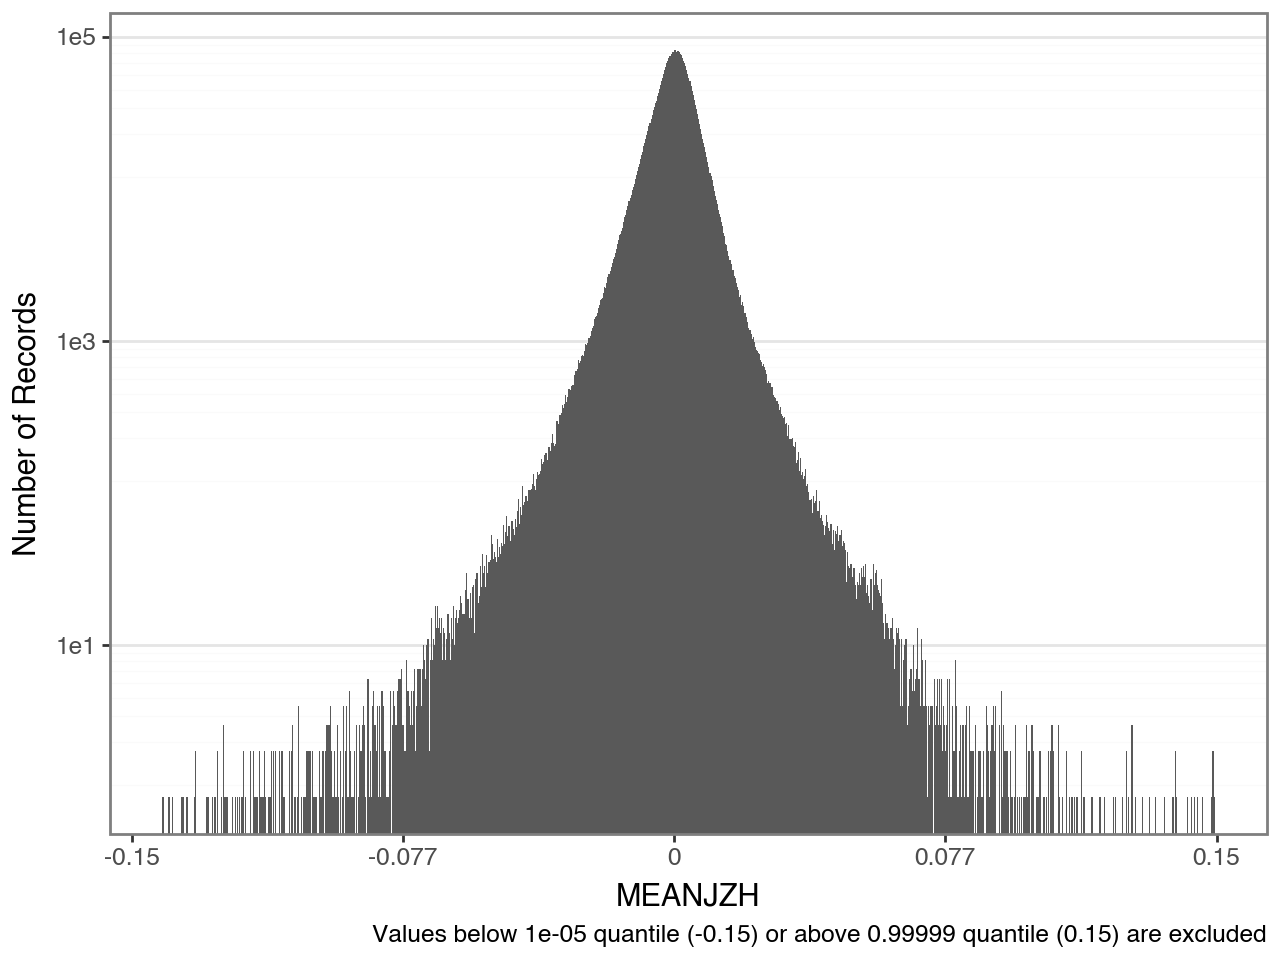

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


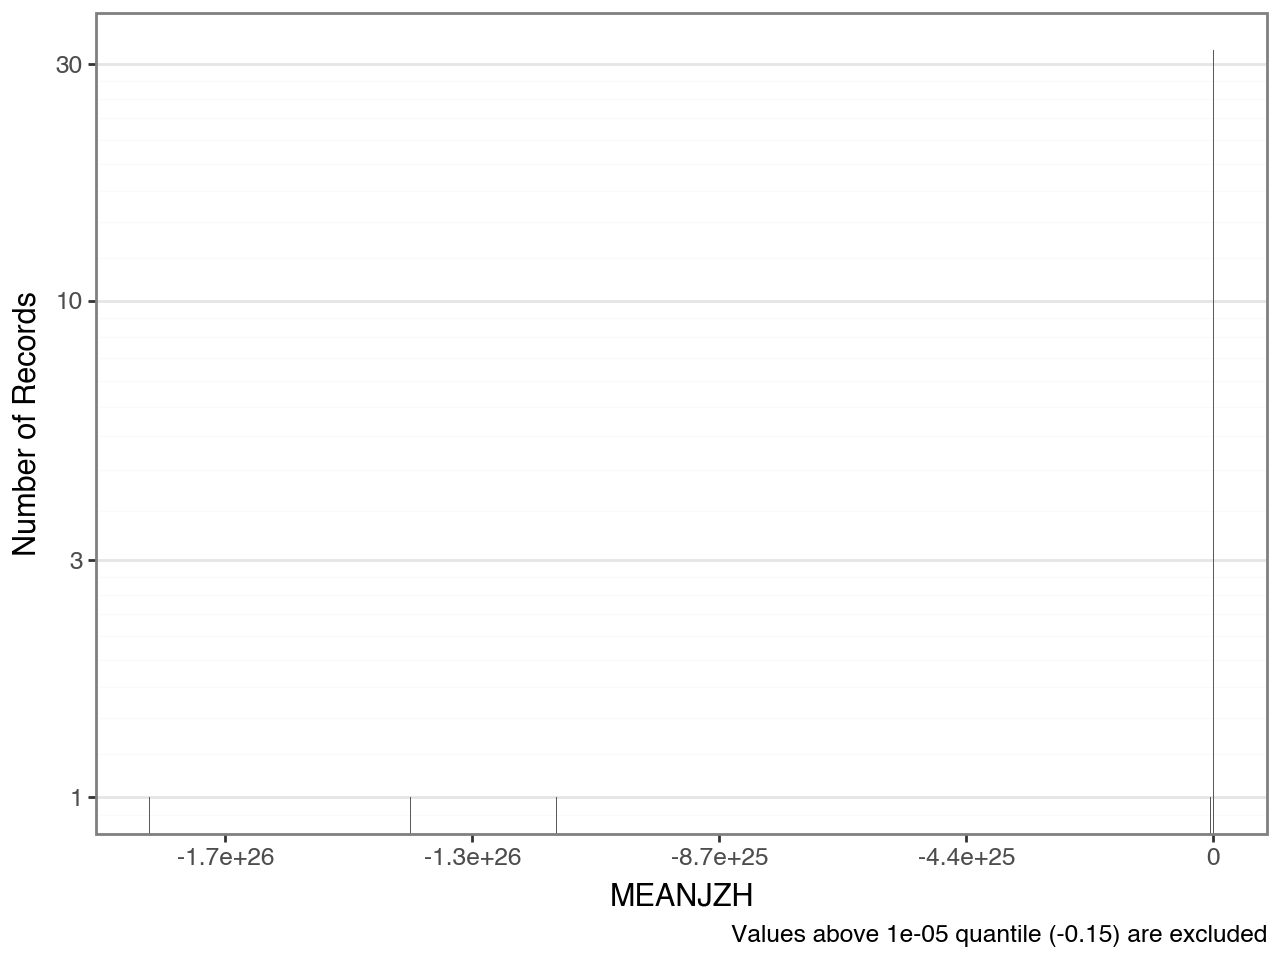

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


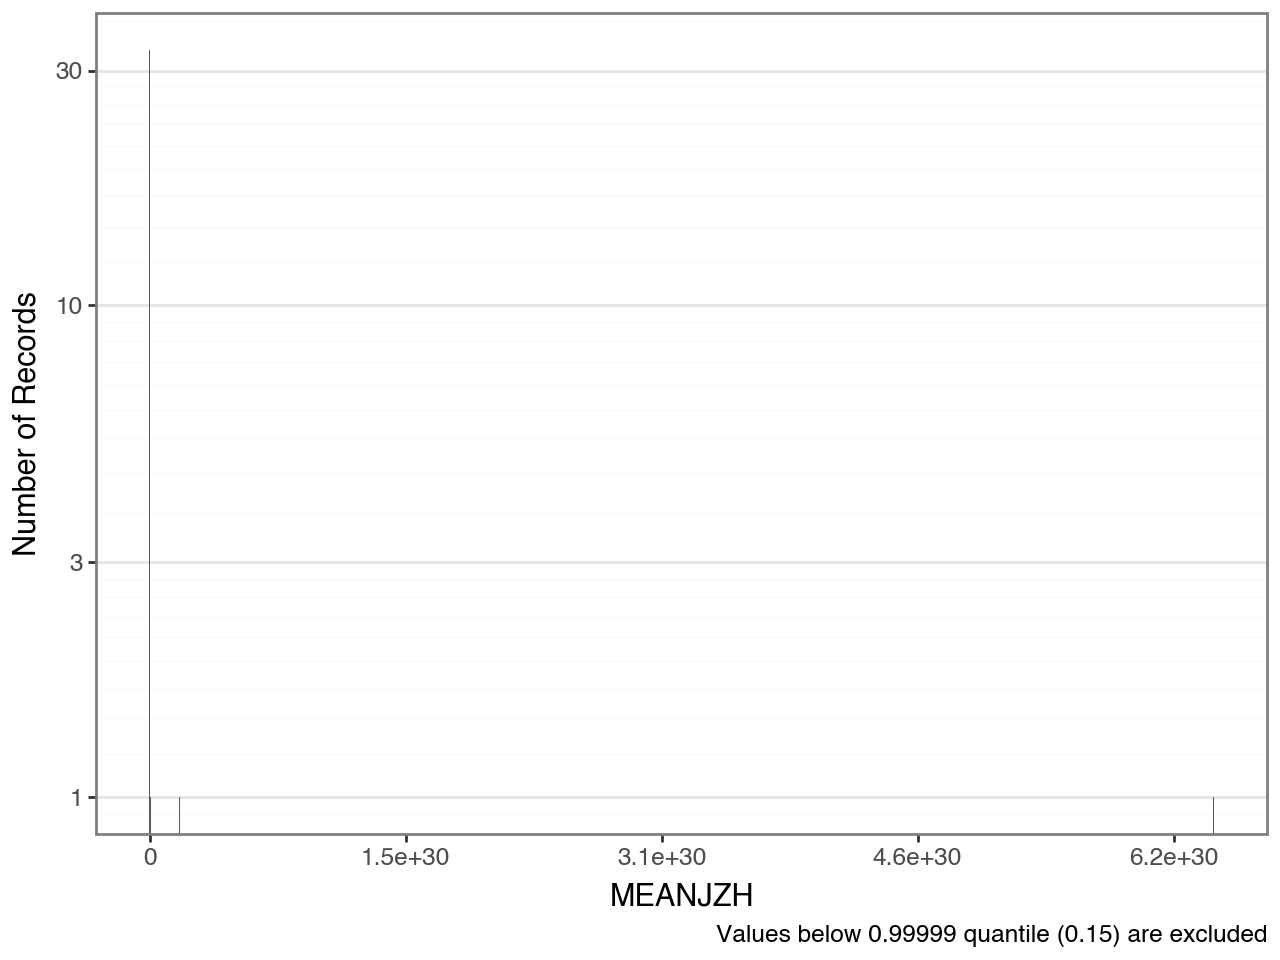

In [19]:
meanjzh_body_histogram = make_histogram(
    "MEANJZH",
    low_quantile_level=1e-5, high_quantile_level=1 - 1e-5,
    use_log_scale_for_y=True
)
meanjzh_left_tail_histogram = make_histogram(
    "MEANJZH", high_quantile_level=1e-5, use_log_scale_for_y=True
)
meanjzh_right_tail_histogram = make_histogram(
    "MEANJZH", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
meanjzh_body_histogram.show()
meanjzh_left_tail_histogram.show()
meanjzh_right_tail_histogram

We replace the dubious values with `np.nan`.

In [20]:
meanjzh_quantiles = harp_data["MEANJZH"].quantile([1e-5, 1 - 1e-5])
harp_data.loc[
    ~harp_data["MEANJZH"].between(
        meanjzh_quantiles.iloc[0], meanjzh_quantiles.iloc[1]
    ),
    "MEANJZH"
] = np.nan

Values of `TOTUSJH` above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


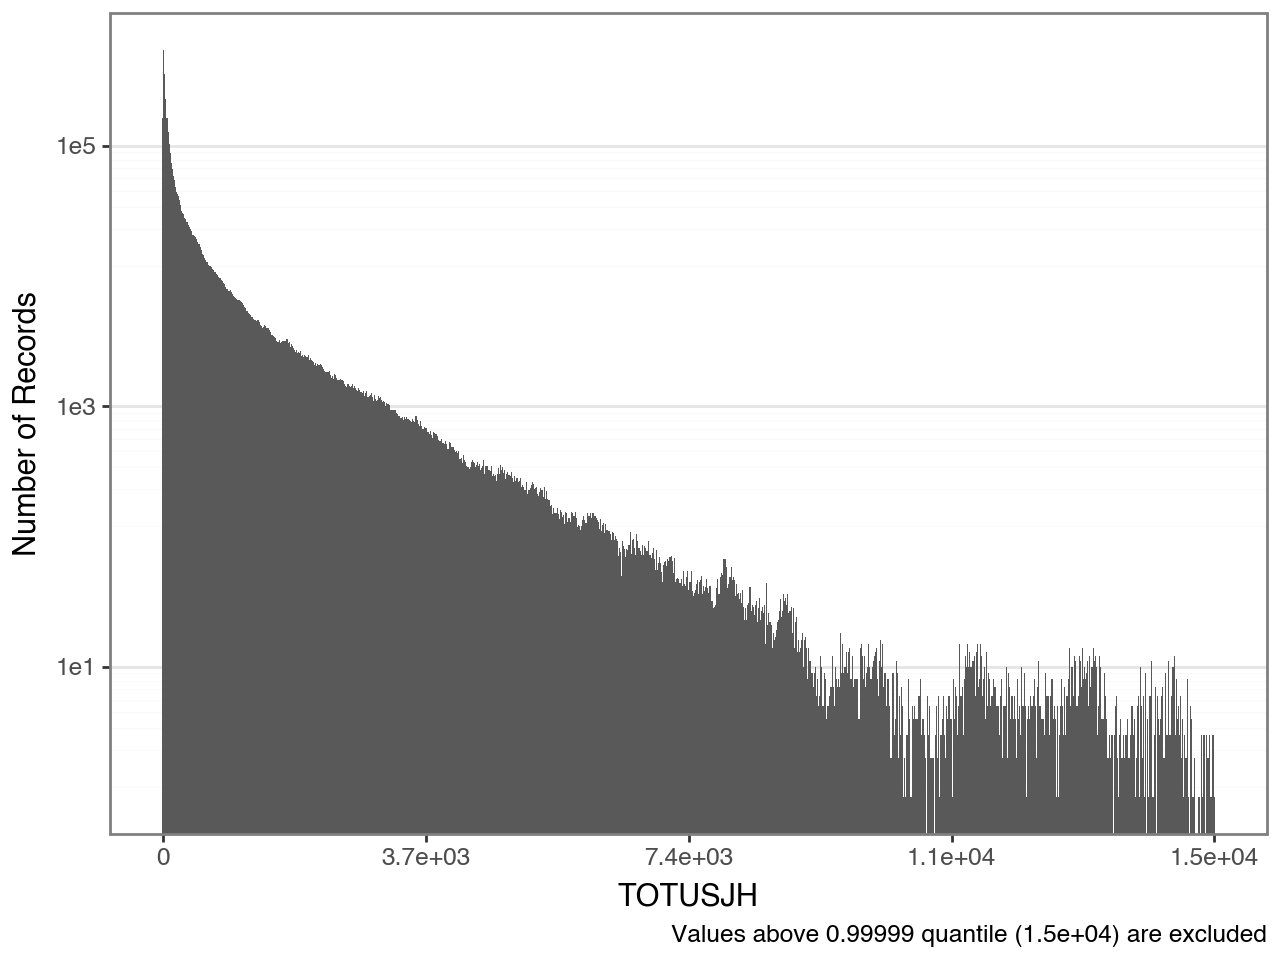

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


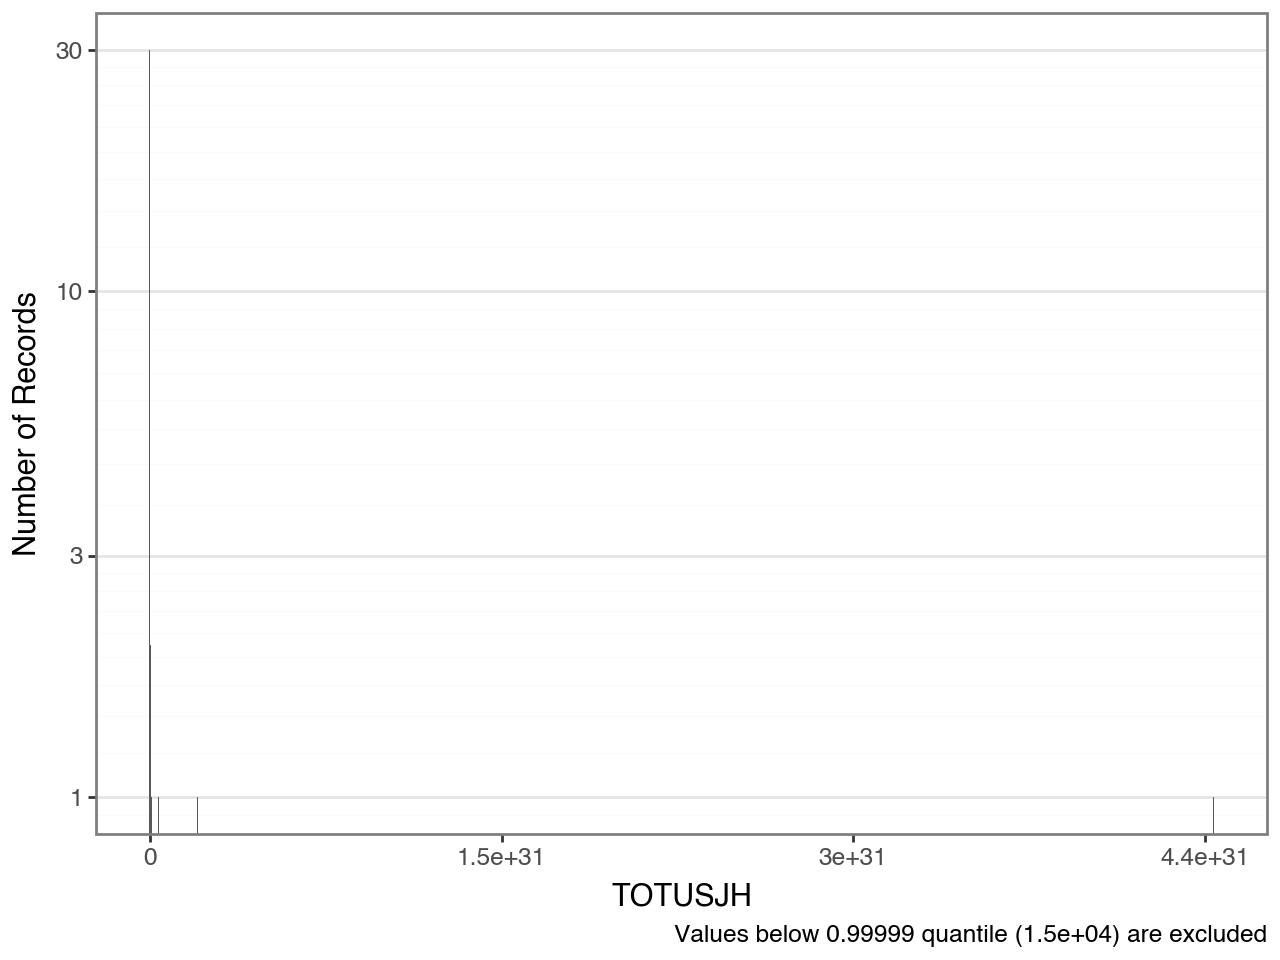

In [21]:
totusjh_body_histogram = make_histogram(
    "TOTUSJH", high_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
totusjh_right_tail_histogram = make_histogram(
    "TOTUSJH", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
totusjh_body_histogram.show()
totusjh_right_tail_histogram

We replace the dubious values with `np.nan`.

In [22]:
harp_data.loc[
    harp_data["TOTUSJH"] > harp_data["TOTUSJH"].quantile(1 - 1e-5), "TOTUSJH"
] = np.nan

Values of `ABSNJZH` above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


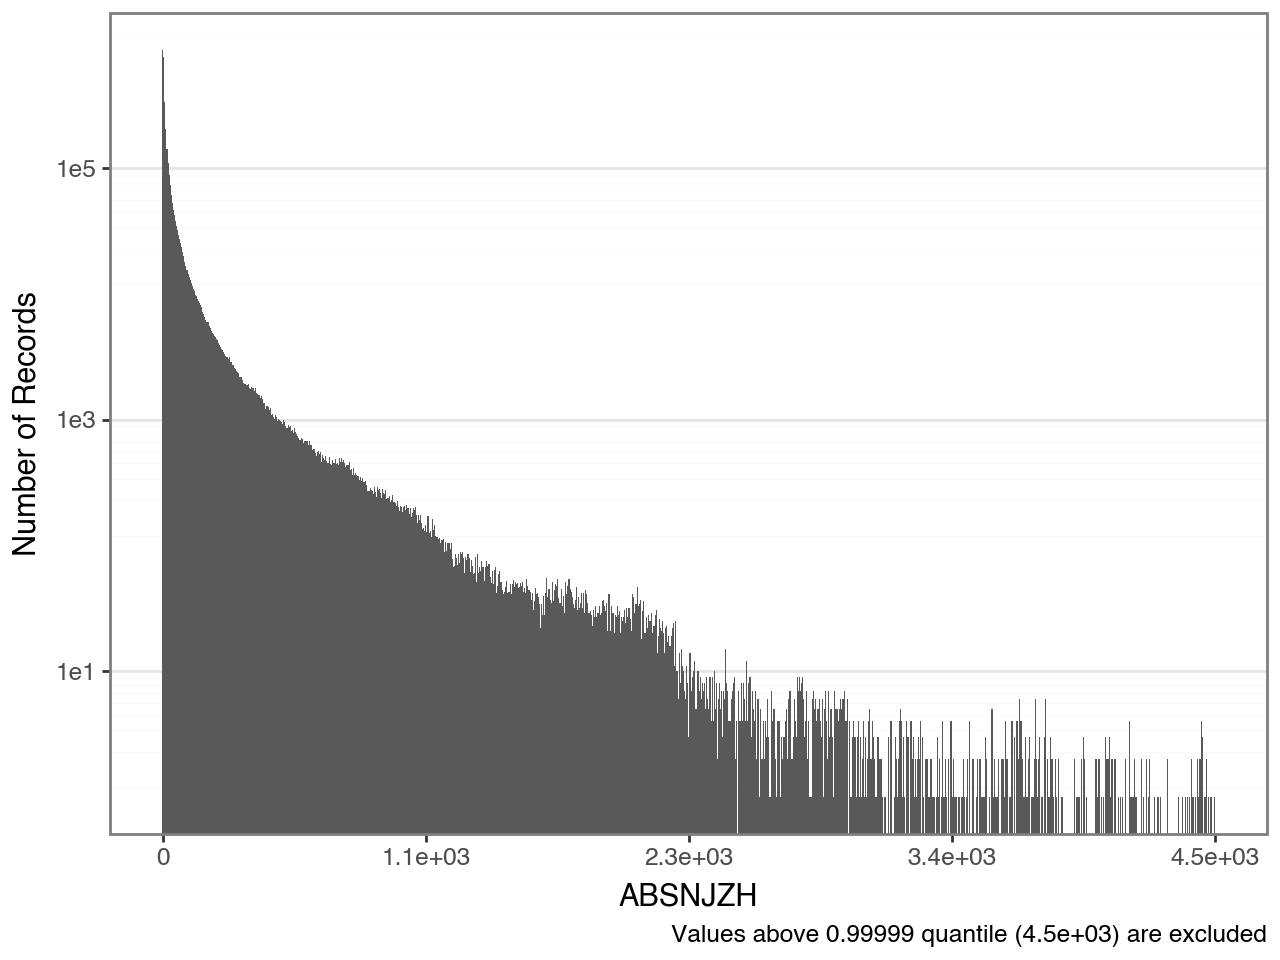

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


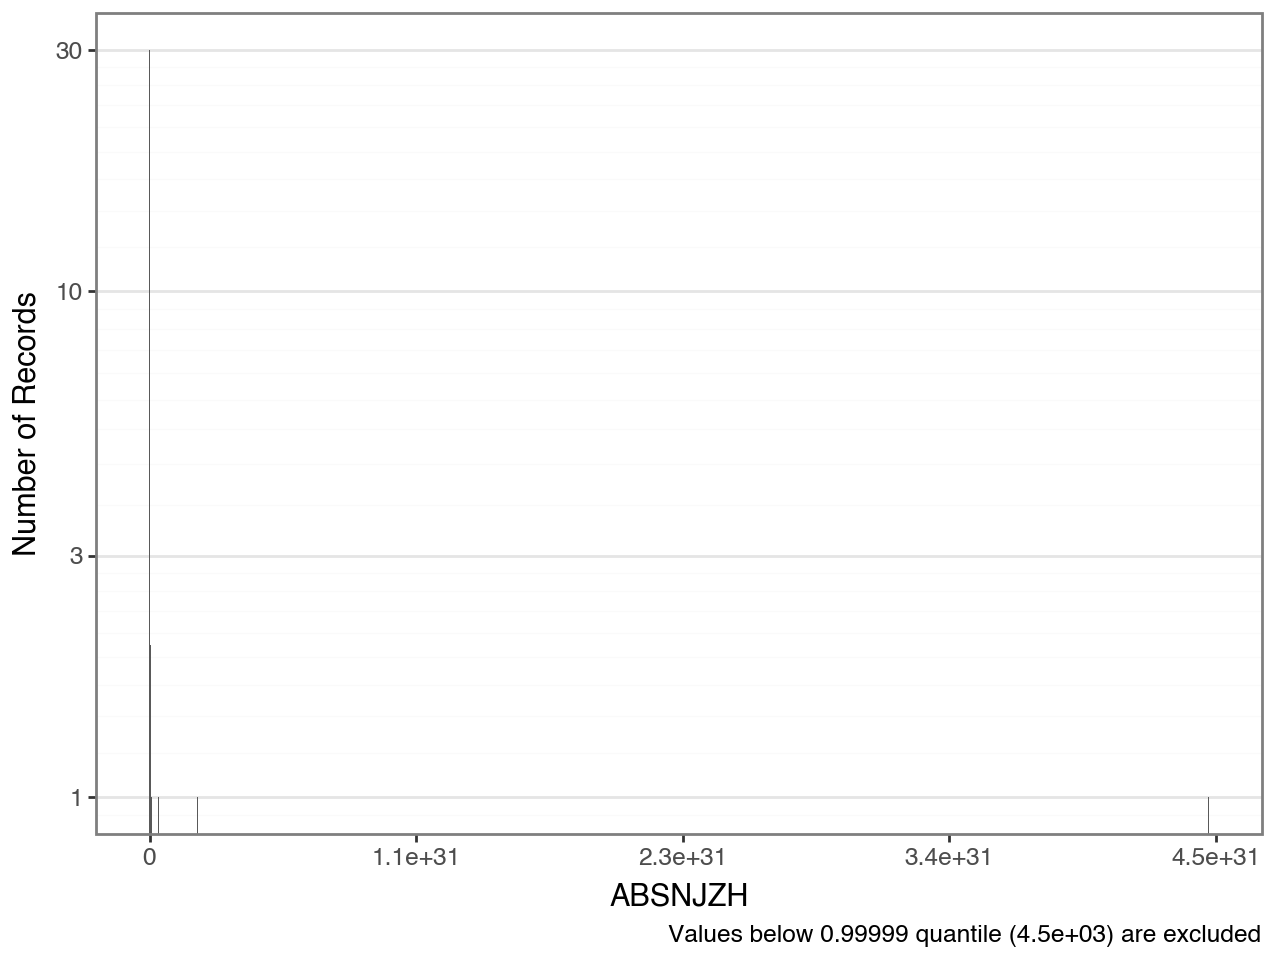

In [23]:
absnjzh_body_histogram = make_histogram(
    "ABSNJZH", high_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
absnjzh_right_tail_histogram = make_histogram(
    "ABSNJZH", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
absnjzh_body_histogram.show()
absnjzh_right_tail_histogram

We replace the dubious values with `np.nan`.

In [24]:
harp_data.loc[
    harp_data["ABSNJZH"] > harp_data["ABSNJZH"].quantile(1 - 1e-5), "ABSNJZH"
] = np.nan

Values of `SAVNCPP` above the `1 - 1e-5` quantile look dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


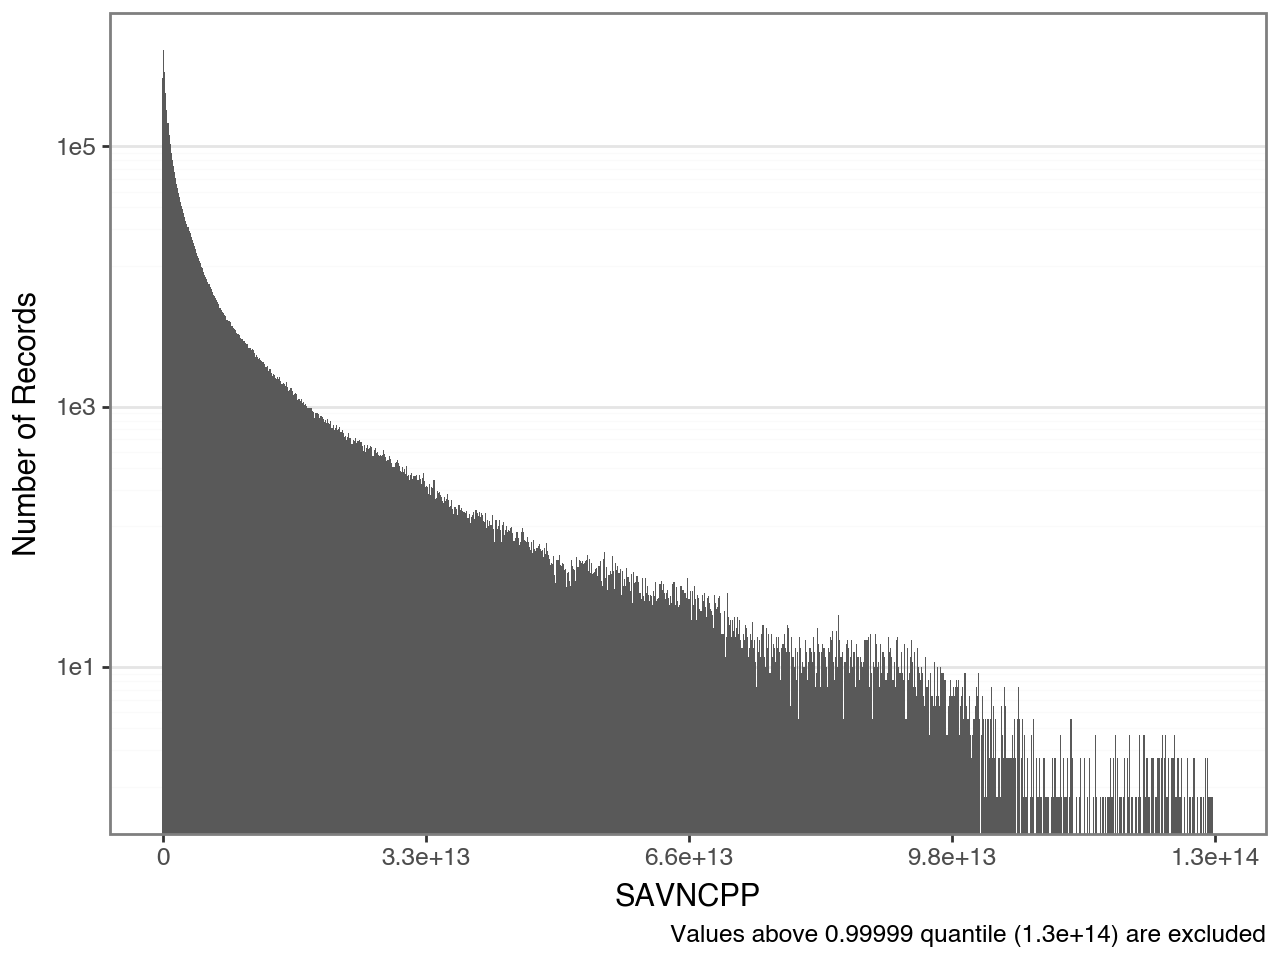

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


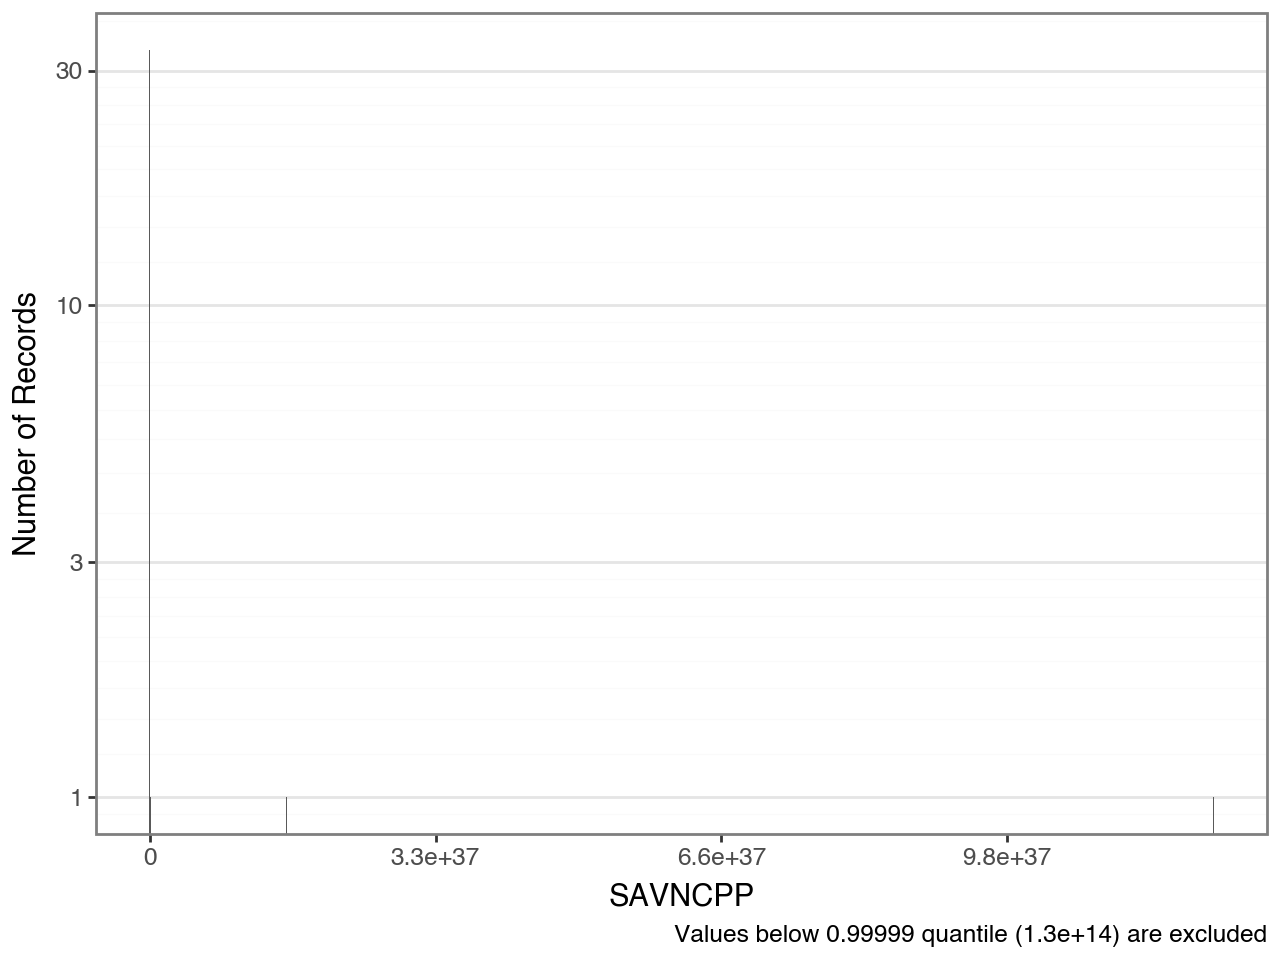

In [25]:
savncpp_body_histogram = make_histogram(
    "SAVNCPP", high_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
savncpp_right_tail_histogram = make_histogram(
    "SAVNCPP", low_quantile_level=1 - 1e-5, use_log_scale_for_y=True
)
savncpp_body_histogram.show()
savncpp_right_tail_histogram

We replace the dubious values with `np.nan`.

In [26]:
harp_data.loc[
    harp_data["SAVNCPP"] > harp_data["SAVNCPP"].quantile(1 - 1e-5), "SAVNCPP"
] = np.nan

There is a value of `MEANPOT` around 78000 that looks dubious.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696307 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


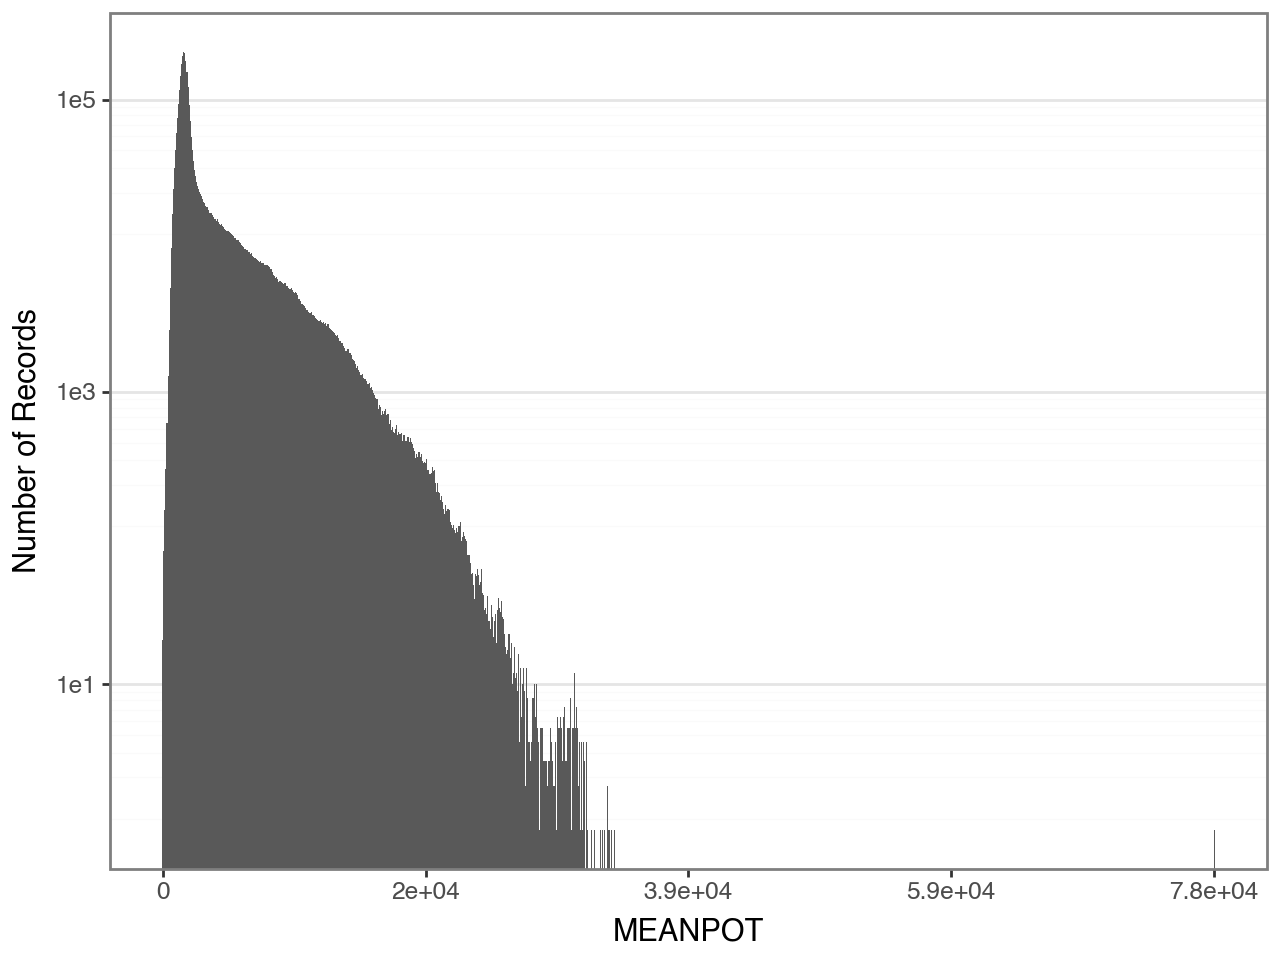

In [27]:
make_histogram("MEANPOT", use_log_scale_for_y=True)

We replace the dubious value with `np.nan`.

In [28]:
harp_data.loc[harp_data["MEANPOT"] > 70000, "MEANPOT"] = np.nan

There don't seem to be any dubious values of `TOTPOT`, although the lack of values around `4e24` looks weird.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


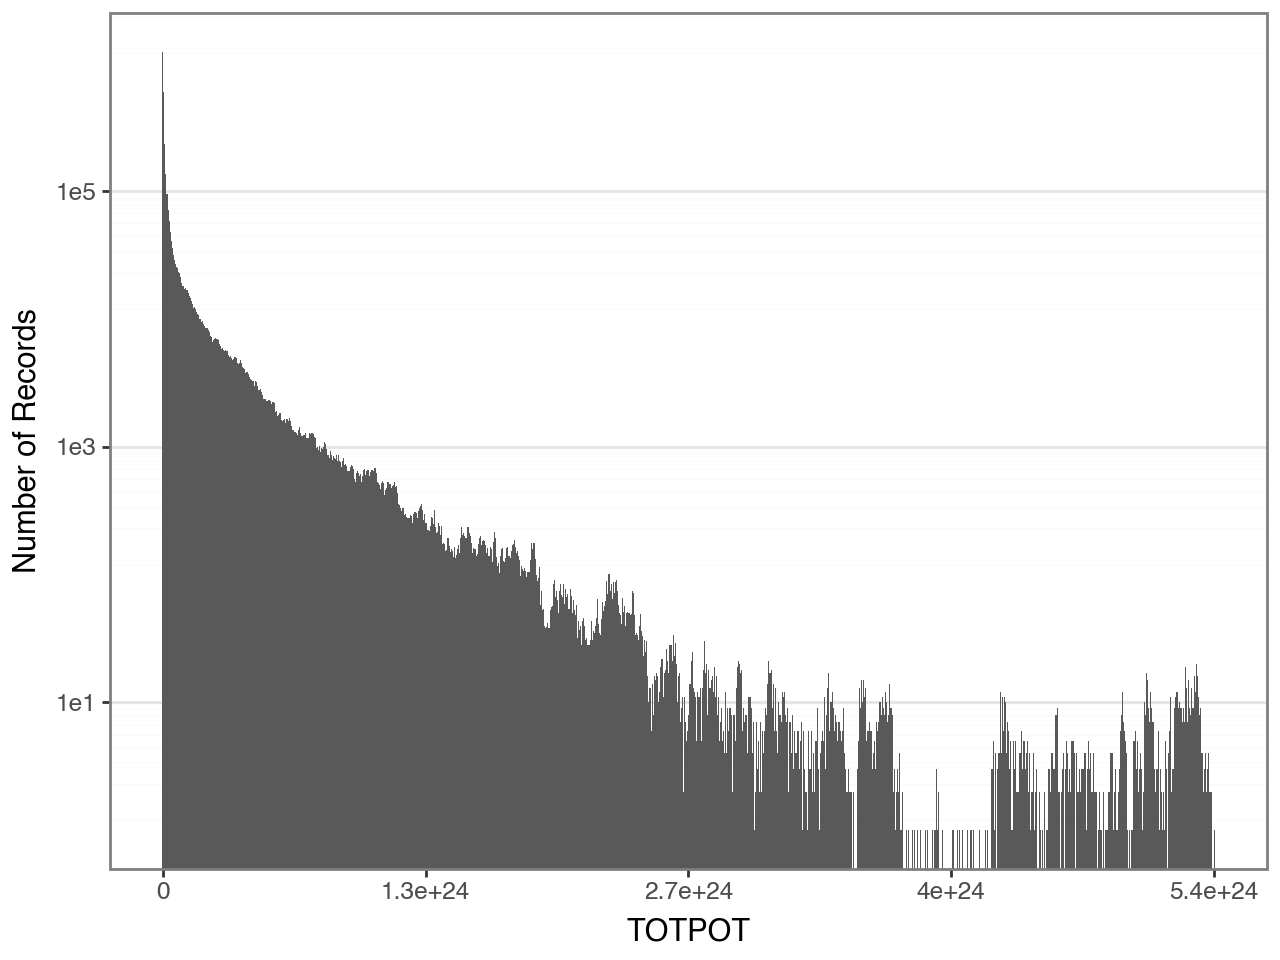

In [29]:
make_histogram("TOTPOT", use_log_scale_for_y=True)

Values of `MEANSHR` above around 90 look dubious maybe?

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 699995 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


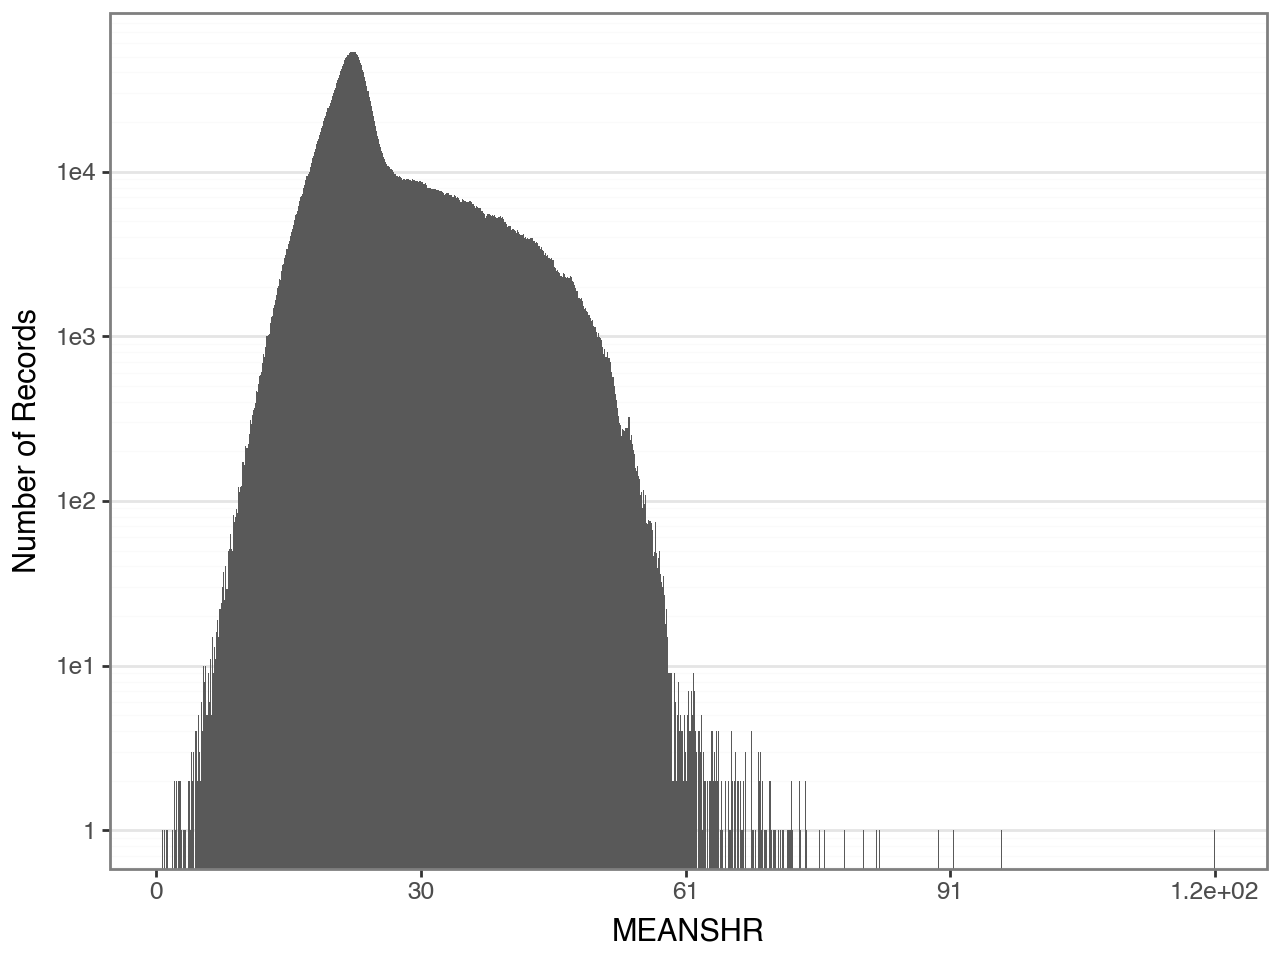

In [30]:
make_histogram("MEANSHR", use_log_scale_for_y=True)

We replace the dubious values with `np.nan`.

In [31]:
harp_data.loc[harp_data["MEANSHR"] > 90, "MEANSHR"] = np.nan

I'm not sure whether to consider any values of `SHRGT45` dubious, though the spike at 100 does look weird. I won't replace any values with `np.nan`.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 696307 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


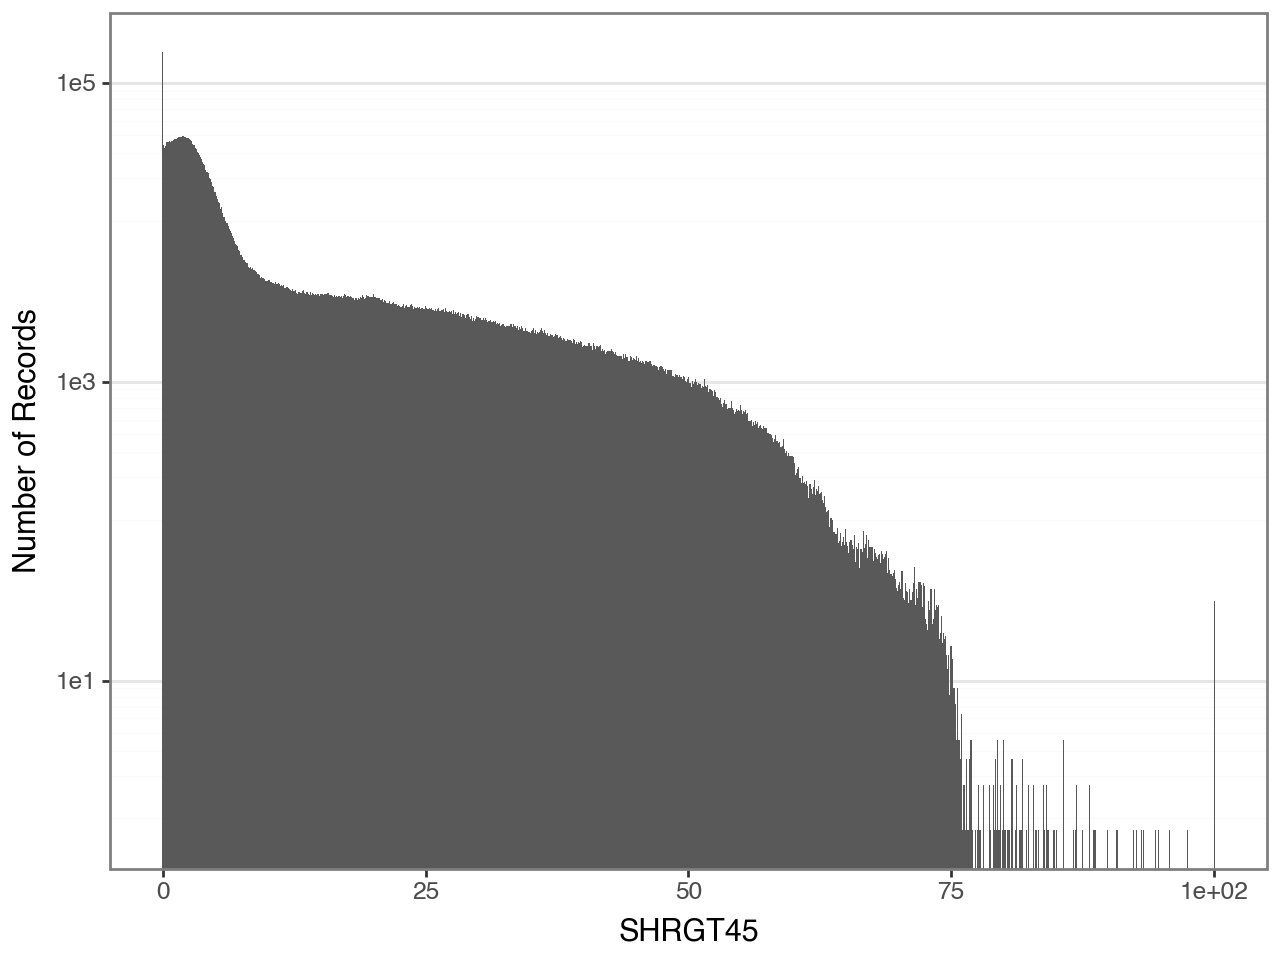

In [32]:
make_histogram("SHRGT45", use_log_scale_for_y=True)

There don't seem to be any dubious values of `NPIX`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


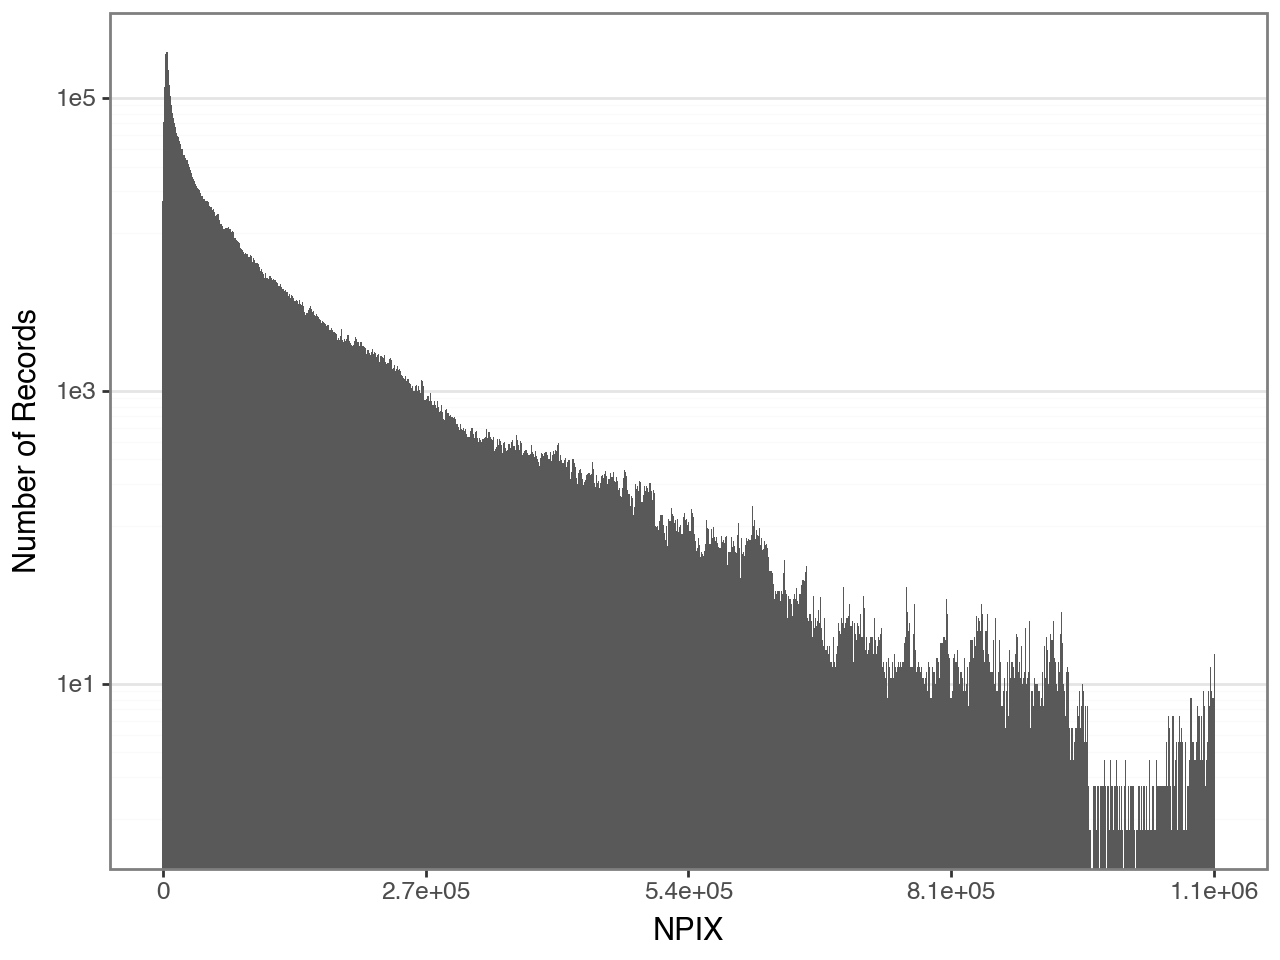

In [33]:
make_histogram("NPIX", use_log_scale_for_y=True)

There don't seem to be any dubious values of `SIZE`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


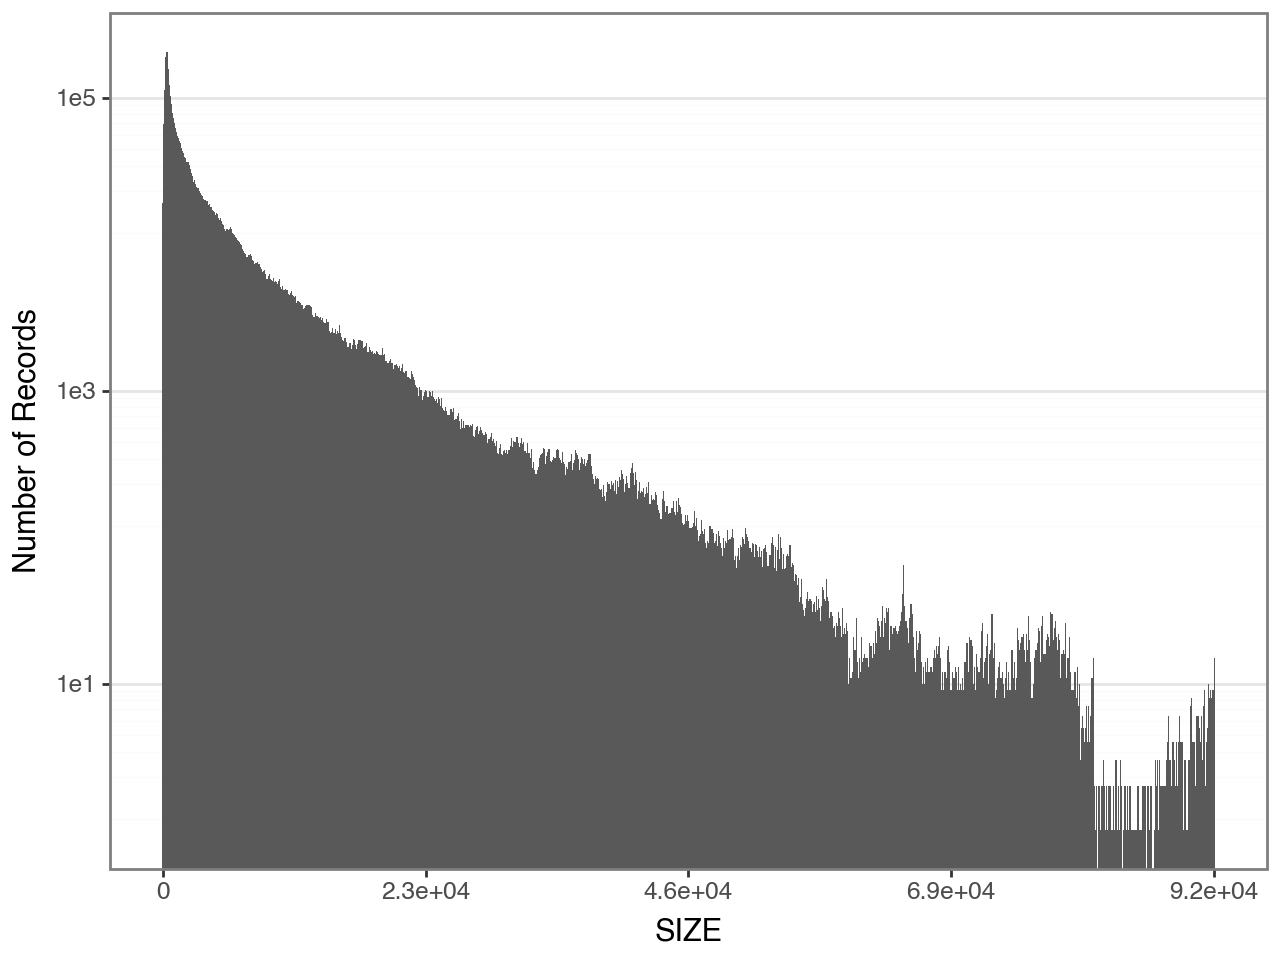

In [34]:
make_histogram("SIZE", use_log_scale_for_y=True)

There don't seem to be any dubious values of `AREA`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


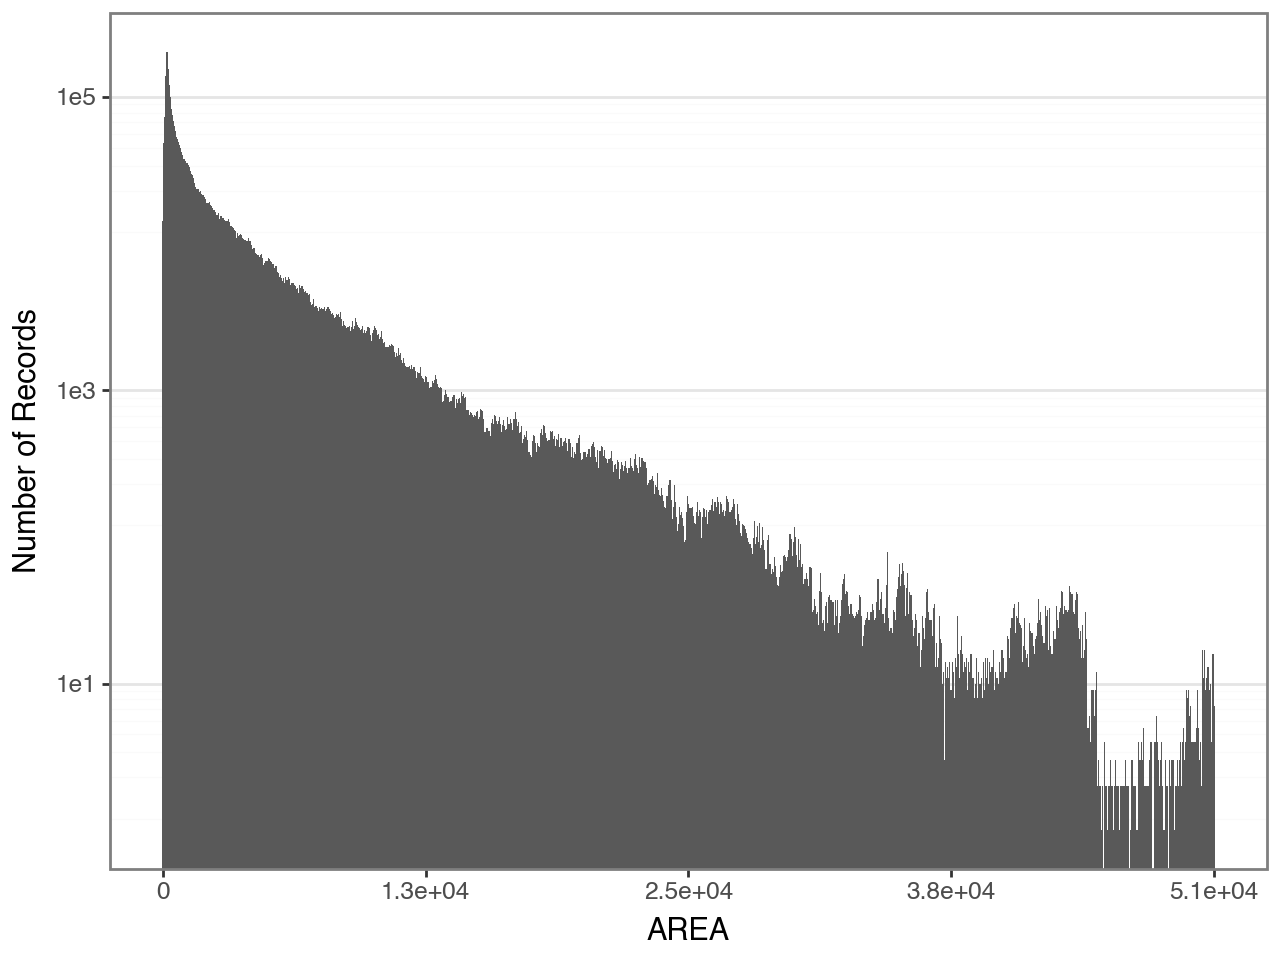

In [35]:
make_histogram("AREA", use_log_scale_for_y=True)

There don't seem to be any dubious values of `NACR`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


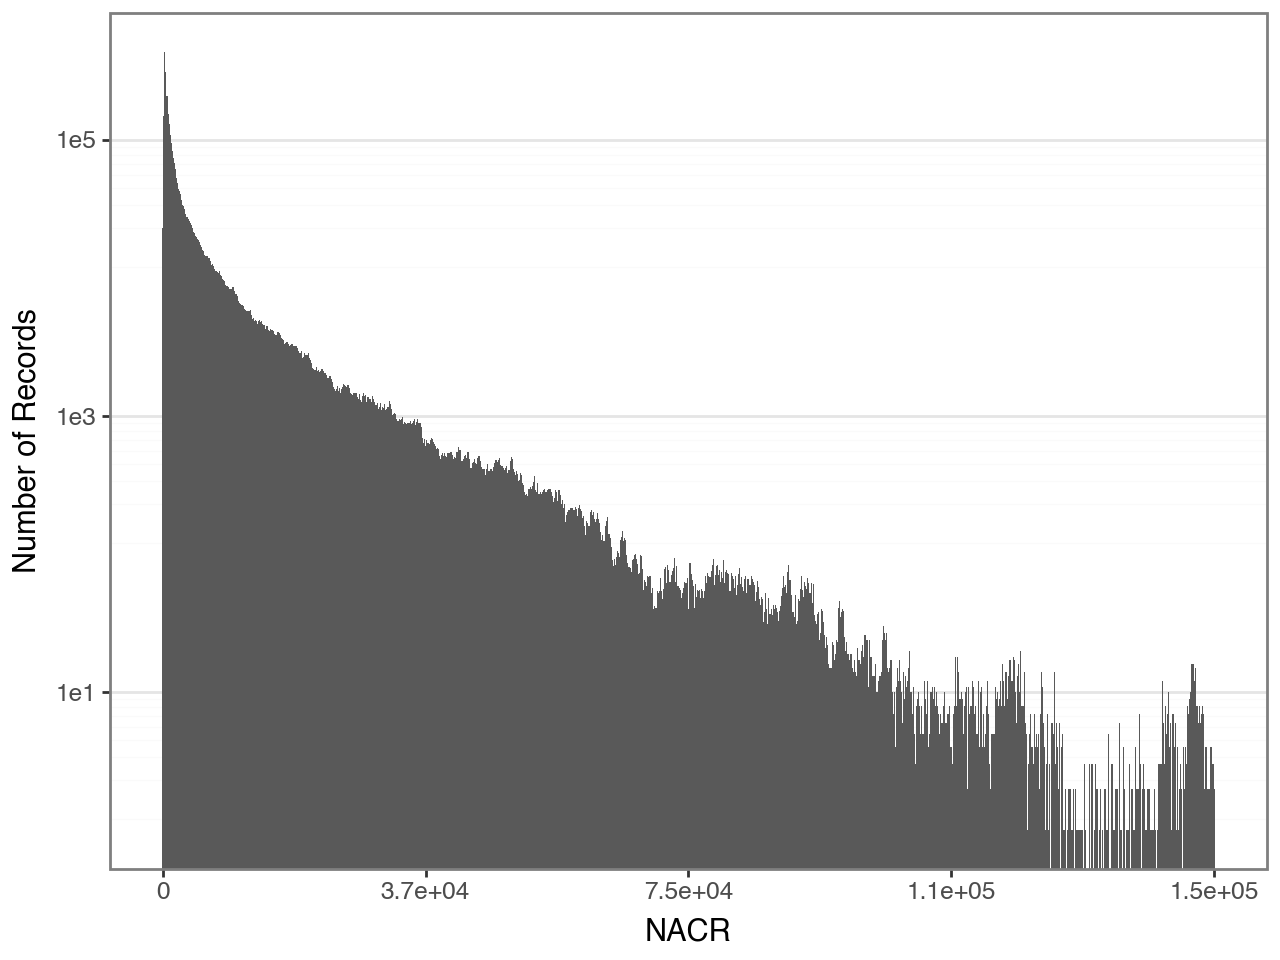

In [36]:
make_histogram("NACR", use_log_scale_for_y=True)

There don't seem to be any dubious values of `SIZE_ACR`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


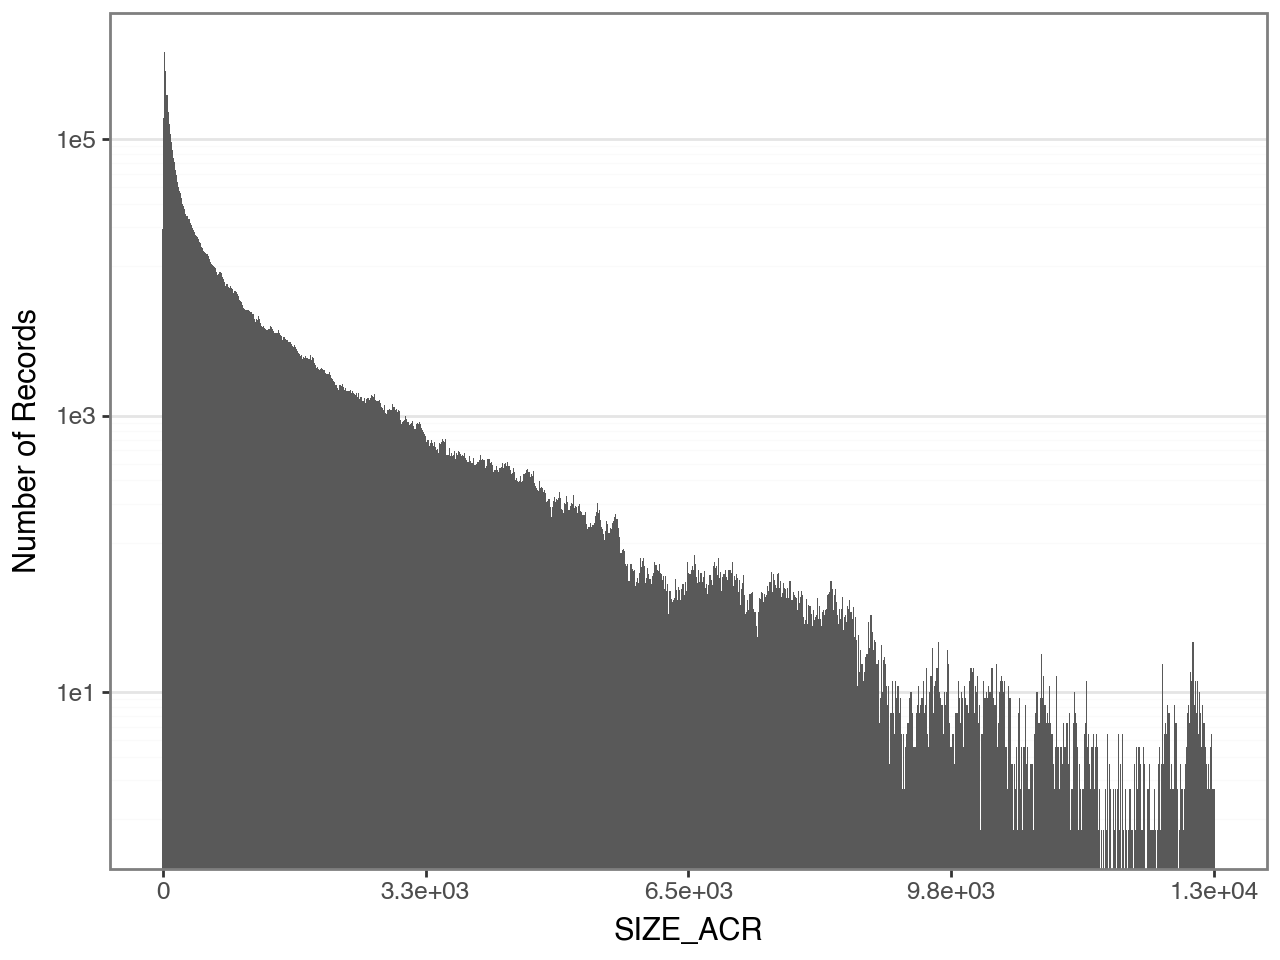

In [37]:
make_histogram("SIZE_ACR", use_log_scale_for_y=True)

There don't seem to be any dubious values of `AREA_ACR`, though some of the counts on the right look weirdly low.

/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 695299 rows containing non-finite values.
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/vkverma/research/harp_data/env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


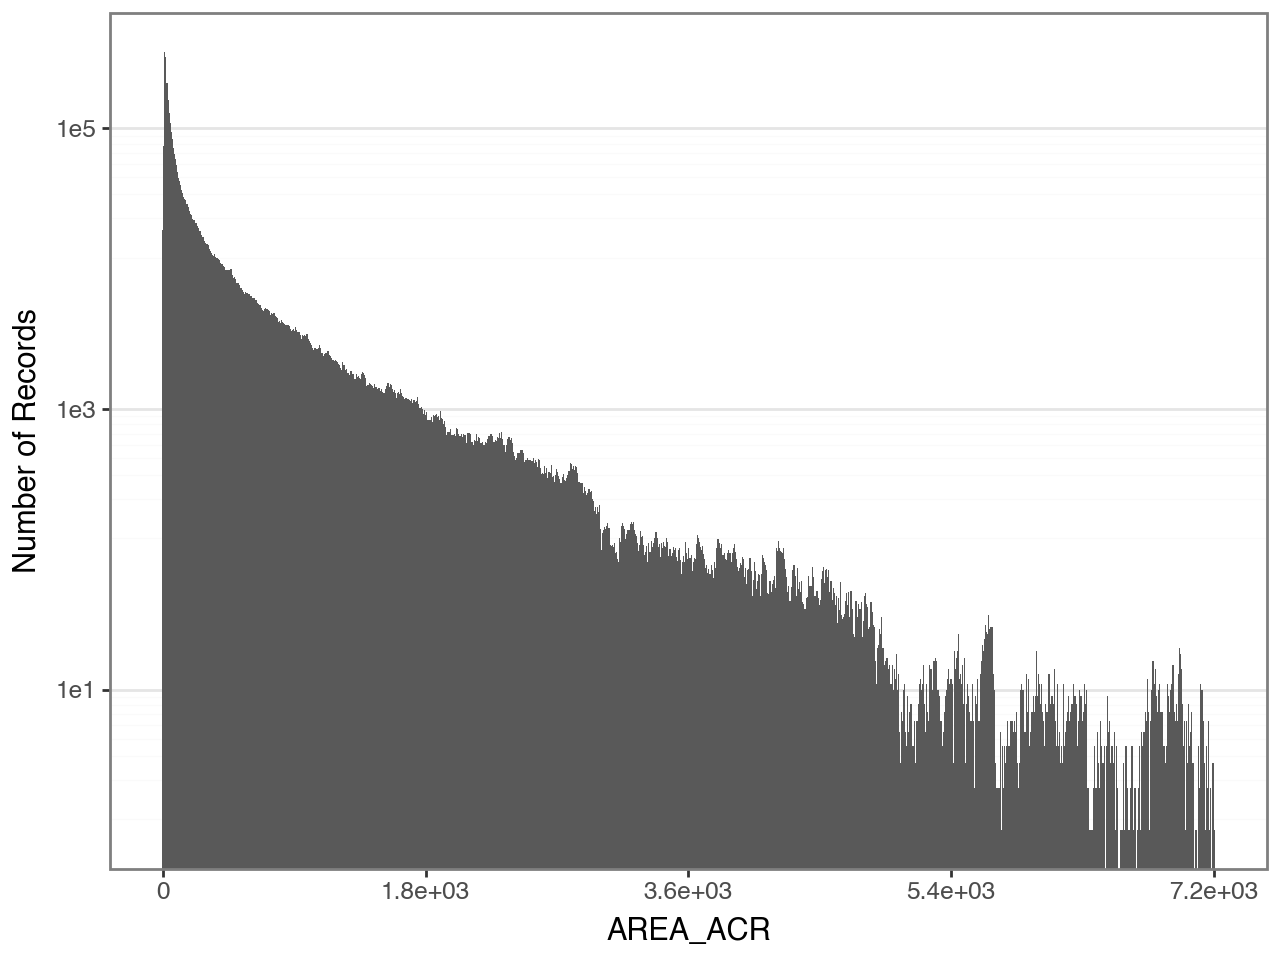

In [38]:
make_histogram("AREA_ACR", use_log_scale_for_y=True)

Save the data.

In [39]:
harp_data.to_parquet("../../processed/hq_nc70_no.parquet")